In [1]:
import os
# os.environ["CUDA_VISIBLE_DEVICES"] = "-1" 
import time
import numpy as np
import torch
print("PyTorch version:",torch.__version__)
if torch.cuda.is_available():
    for i in range(torch.cuda.device_count()):
      print(f"CUDA GPU {i+1}: {torch.cuda.get_device_name(i)} [Compute Capability: {torch.cuda.get_device_capability(0)[0]}.{torch.cuda.get_device_capability(0)[1]}]")
    device = torch.device('cuda')
    kwargs = {'num_workers': 8, 'pin_memory': True}
    torch.backends.cudnn.benchmark = True
else:
    device = torch.device('cpu')
    print("CUDA GPU is not available. :(")  
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset

import pytorch_lightning as pl
from pytorch_lightning.loggers import TensorBoardLogger
print ("PyTorch Lightning version:",pl.__version__)
    
import scipy.sparse as sp
from argparse import Namespace

from utilities.custom_lightning import CSVProfiler

import logging
logger = logging.getLogger()
logger.setLevel(logging.DEBUG)
logging.debug("Logging enabled at DEBUG level.")

from constants import (SEED, DATA_DIR, LOG_DIR, TRAIN_DATA_PATH, VAL_DATA_PATH, TEST_DATA_PATH)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)

import optuna
from optuna.integration import PyTorchLightningPruningCallback
print("Optuna version:",optuna.__version__)

PyTorch version: 1.5.0
CUDA GPU 1: GeForce RTX 2080 Ti [Compute Capability: 7.5]
PyTorch Lightning version: 0.7.6


DEBUG:root:Logging enabled at DEBUG level.


Optuna version: 1.5.0


In [2]:
NAME = r'AdamOptunaUXML' 
SAVE_PATH = DATA_DIR+r'/'+NAME+r'.pt'
PROFILE_PATH = LOG_DIR+'\\'+NAME+'\\profile.csv'

In [3]:
class Interactions(Dataset):
    """
    Create interactions matrix.
    """

    def __init__(self, matrix):
        self.matrix = matrix
        self.n_users = self.matrix.shape[0]
        self.n_items = self.matrix.shape[1]

    def __getitem__(self, index):
        row = self.matrix.row[index]
        col = self.matrix.col[index]
        val = self.matrix.data[index]
        return (row, col), val

    def __len__(self):
        return self.matrix.nnz
    
interaction = Interactions

In [4]:
class TestingCallbacks(pl.Callback):
    def on_test_start(self, trainer, pl_module):
        global y_hat 
        y_hat = sp.dok_matrix((hparams.total_users, hparams.total_items), dtype=np.float32) 
    def on_test_end(self, trainer, pl_module):
        logging.debug(f"Non-zero values in prediction matrix: {y_hat.nnz:,}")
        sp.save_npz(DATA_DIR+NAME+r'-y_hat.npz',y_hat.tocoo())

In [5]:
class MetricsCallback(pl.Callback):
    def __init__(self):
        super().__init__()
        self.metrics = []
    def on_validation_end(self, trainer, pl_module):
        self.metrics.append(trainer.callback_metrics)

In [6]:
class AdamUXML(pl.LightningModule):
    def __init__(self, trial, hparams):
        super(AdamUXML, self).__init__() 
        self.hparams = hparams
        
        n_factors = trial.suggest_int("n_factors", 5, 40)
        dropout_p = trial.suggest_uniform("dropout_p", 0.0, 0.8)
        
        self.user_factors = nn.Embedding(hparams.total_users, n_factors, sparse=hparams.sparse)
        self.item_factors = nn.Embedding(hparams.total_items, n_factors, sparse=hparams.sparse)
        self.user_biases = nn.Embedding(hparams.total_users, 1, sparse=hparams.sparse)
        self.item_biases = nn.Embedding(hparams.total_items, 1, sparse=hparams.sparse)
        self.dropout = nn.Dropout(p=dropout_p)
        
    def forward(self, users, items):            
        
        user_factors_users = self.user_factors(users)
        item_factors_items = self.item_factors(items)        
        predictions = self.user_biases(users)
        predictions += self.item_biases(items)
        predictions += (self.dropout(user_factors_users) * self.dropout(item_factors_items)).sum(dim=1, keepdim=True)              
        return predictions.squeeze()
    
    def MSELoss(self, logits, labels):
        return nn.functional.mse_loss(logits, labels)
    
    def training_step(self, train_batch, batch_idx):
        x, y = train_batch
        row, column = x
        row = row.long()
        column = column.long()
        logits = self.forward(row,column)
        loss = self.MSELoss(logits, y)
        logs = {'train_loss': loss}
        return {'loss': loss}

    def validation_step(self, val_batch, batch_idx):
        x, y = val_batch
        row, column = x
        row = row.long()
        column = column.long()
        logits = self.forward(row,column)                
        loss = self.MSELoss(logits, y)
        return {'val_loss': loss}
    
    def validation_epoch_end(self, outputs):
        avg_loss = torch.stack([x['val_loss'] for x in outputs]).mean()
        return {"log": {"avg_val_loss": avg_loss}}
    
    def test_step(self, test_batch, batch_idx):
        x, y = test_batch
        row, column = x
        row = row.long()
        column = column.long()
        logits = self.forward(row,column)                
        loss = self.MSELoss(logits, y)        
       
        logits_array = logits.cpu().numpy()
        r = row.cpu().numpy()
        c = column.cpu().numpy()
        for i in range(len(logits_array)):
            y_hat[r[i],c[i]]=logits_array[i]      
        return {'test_loss': loss}
    
    def test_epoch_end(self, outputs):
        avg_loss = torch.stack([x['test_loss'] for x in outputs]).mean()
        tensorboard_logs = {'MSE': avg_loss}
        print(f"Test Mean Squared Error (MSE): {avg_loss}")                   
        return {"log": {"avg_test_loss": avg_loss}}
      
    def prepare_data(self):
        self.train_dataset = sp.load_npz(TRAIN_DATA_PATH)
        self.val_dataset = sp.load_npz(VAL_DATA_PATH)
        self.test_dataset = sp.load_npz(TEST_DATA_PATH)
        
    def train_dataloader(self):
        return DataLoader(interaction(self.train_dataset), batch_size=self.hparams.batch_size, shuffle=True)
    
    def val_dataloader(self):
        return DataLoader(interaction(self.val_dataset), batch_size=self.hparams.batch_size, shuffle=False)
    
    def test_dataloader(self):
        return DataLoader(interaction(self.test_dataset), batch_size=self.hparams.batch_size, shuffle=False)
      
    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(),
                                     lr=self.hparams.learning_rate,
                                     betas=self.hparams.betas,
                                     amsgrad=self.hparams.amsgrad)
        return optimizer

In [7]:
uxm = sp.load_npz(TRAIN_DATA_PATH)
total_users = uxm.shape[0]
total_items = uxm.shape[1]
del uxm

In [8]:
def objective(trial):
    checkpoint_callback = pl.callbacks.ModelCheckpoint(
        os.path.join(LOG_DIR+"\Optuna","trial_{}".format(trial.number), "{epoch}"), monitor="avg_val_loss"
    )

    metrics_callback = MetricsCallback()
    trainer = pl.Trainer(
        logger=False,
        val_percent_check=hparams.val_percent_check,
        checkpoint_callback=checkpoint_callback,
        max_epochs=hparams.max_epochs,
        gpus=1,
        callbacks=[metrics_callback],
        early_stop_callback=PyTorchLightningPruningCallback(trial, monitor="avg_val_loss"),
    )

    model = AdamUXML(trial, hparams)
    trainer.fit(model)

    return metrics_callback.metrics[-1]["avg_val_loss"]

In [9]:
hparams = Namespace(**{
    'batch_size': 1024,
    'val_percent_check': 1.0, # set this to <1.0 to use data subset for validation
    'learning_rate': 0.001, 
    'betas': (0.9, 0.999),
#     'dropout_p': 0.2, ### delegated to Optuna
#     'n_factors': 20, ### delegated to Optuna    
    'sparse': False,
    'max_epochs': 10,
    'amsgrad': False,
    'action':"store_true", # do we need this?
    'pruning': True,
    'total_users': total_users,
    'total_items': total_items
})

In [10]:
start_time = time.time() 

pruner = optuna.pruners.MedianPruner() if hparams.pruning else optuna.pruners.NopPruner()

study = optuna.create_study(direction='minimize', pruner=pruner)
study.optimize(objective, n_trials=100, timeout=None)

print("Number of finished trials: {}".format(len(study.trials)))

print("Best trial:")
trial = study.best_trial

print("  Value: {}".format(trial.value))

print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))
    
print(f"Elapsed time: {time.time()-start_time:.2f} seconds") 

GPU available: True, used: True
INFO:lightning:GPU available: True, used: True
No environment variable for node rank defined. Set as 0.
CUDA_VISIBLE_DEVICES: [0]
INFO:lightning:CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type      | Params
---------------------------------------
0 | user_factors | Embedding | 2 M   
1 | item_factors | Embedding | 716 K 
2 | user_biases  | Embedding | 177 K 
3 | item_biases  | Embedding | 44 K  
4 | dropout      | Dropout   | 0     
INFO:lightning:
  | Name         | Type      | Params
---------------------------------------
0 | user_factors | Embedding | 2 M   
1 | item_factors | Embedding | 716 K 
2 | user_biases  | Embedding | 177 K 
3 | item_biases  | Embedding | 44 K  
4 | dropout      | Dropout   | 0     


[I 2020-06-06 19:28:06,860] Finished trial#0 with value: 1.360329508781433 with parameters: {'n_factors': 16, 'dropout_p': 0.28339097027307975}. Best is trial#0 with value: 1.360329508781433.
GPU available: True, used: True
INFO:lightning:GPU available: True, used: True
No environment variable for node rank defined. Set as 0.
CUDA_VISIBLE_DEVICES: [0]
INFO:lightning:CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type      | Params
---------------------------------------
0 | user_factors | Embedding | 2 M   
1 | item_factors | Embedding | 582 K 
2 | user_biases  | Embedding | 177 K 
3 | item_biases  | Embedding | 44 K  
4 | dropout      | Dropout   | 0     
INFO:lightning:
  | Name         | Type      | Params
---------------------------------------
0 | user_factors | Embedding | 2 M   
1 | item_factors | Embedding | 582 K 
2 | user_biases  | Embedding | 177 K 
3 | item_biases  | Embedding | 44 K  
4 | dropout      | Dropout   | 0     


[I 2020-06-06 19:30:56,563] Finished trial#1 with value: 1.0264251232147217 with parameters: {'n_factors': 13, 'dropout_p': 0.20906809319775768}. Best is trial#1 with value: 1.0264251232147217.
GPU available: True, used: True
INFO:lightning:GPU available: True, used: True
No environment variable for node rank defined. Set as 0.
CUDA_VISIBLE_DEVICES: [0]
INFO:lightning:CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type      | Params
---------------------------------------
0 | user_factors | Embedding | 1 M   
1 | item_factors | Embedding | 268 K 
2 | user_biases  | Embedding | 177 K 
3 | item_biases  | Embedding | 44 K  
4 | dropout      | Dropout   | 0     
INFO:lightning:
  | Name         | Type      | Params
---------------------------------------
0 | user_factors | Embedding | 1 M   
1 | item_factors | Embedding | 268 K 
2 | user_biases  | Embedding | 177 K 
3 | item_biases  | Embedding | 44 K  
4 | dropout      | Dropout   | 0     


[I 2020-06-06 19:33:47,272] Finished trial#2 with value: 0.42526593804359436 with parameters: {'n_factors': 6, 'dropout_p': 0.003723607692885711}. Best is trial#2 with value: 0.42526593804359436.
GPU available: True, used: True
INFO:lightning:GPU available: True, used: True
No environment variable for node rank defined. Set as 0.
CUDA_VISIBLE_DEVICES: [0]
INFO:lightning:CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type      | Params
---------------------------------------
0 | user_factors | Embedding | 4 M   
1 | item_factors | Embedding | 1 M   
2 | user_biases  | Embedding | 177 K 
3 | item_biases  | Embedding | 44 K  
4 | dropout      | Dropout   | 0     
INFO:lightning:
  | Name         | Type      | Params
---------------------------------------
0 | user_factors | Embedding | 4 M   
1 | item_factors | Embedding | 1 M   
2 | user_biases  | Embedding | 177 K 
3 | item_biases  | Embedding | 44 K  
4 | dropout      | Dropout   | 0     


[I 2020-06-06 19:36:39,306] Finished trial#3 with value: 4.232080459594727 with parameters: {'n_factors': 25, 'dropout_p': 0.6280046733967967}. Best is trial#2 with value: 0.42526593804359436.
GPU available: True, used: True
INFO:lightning:GPU available: True, used: True
No environment variable for node rank defined. Set as 0.
CUDA_VISIBLE_DEVICES: [0]
INFO:lightning:CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type      | Params
---------------------------------------
0 | user_factors | Embedding | 1 M   
1 | item_factors | Embedding | 358 K 
2 | user_biases  | Embedding | 177 K 
3 | item_biases  | Embedding | 44 K  
4 | dropout      | Dropout   | 0     
INFO:lightning:
  | Name         | Type      | Params
---------------------------------------
0 | user_factors | Embedding | 1 M   
1 | item_factors | Embedding | 358 K 
2 | user_biases  | Embedding | 177 K 
3 | item_biases  | Embedding | 44 K  
4 | dropout      | Dropout   | 0     


[I 2020-06-06 19:39:29,511] Finished trial#4 with value: 1.0625261068344116 with parameters: {'n_factors': 8, 'dropout_p': 0.5639956502009288}. Best is trial#2 with value: 0.42526593804359436.
GPU available: True, used: True
INFO:lightning:GPU available: True, used: True
No environment variable for node rank defined. Set as 0.
CUDA_VISIBLE_DEVICES: [0]
INFO:lightning:CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type      | Params
---------------------------------------
0 | user_factors | Embedding | 6 M   
1 | item_factors | Embedding | 1 M   
2 | user_biases  | Embedding | 177 K 
3 | item_biases  | Embedding | 44 K  
4 | dropout      | Dropout   | 0     
INFO:lightning:
  | Name         | Type      | Params
---------------------------------------
0 | user_factors | Embedding | 6 M   
1 | item_factors | Embedding | 1 M   
2 | user_biases  | Embedding | 177 K 
3 | item_biases  | Embedding | 44 K  
4 | dropout      | Dropout   | 0     


[I 2020-06-06 19:40:04,580] Setting status of trial#5 as TrialState.PRUNED. Trial was pruned at epoch 1.
GPU available: True, used: True
INFO:lightning:GPU available: True, used: True
No environment variable for node rank defined. Set as 0.
CUDA_VISIBLE_DEVICES: [0]
INFO:lightning:CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type      | Params
---------------------------------------
0 | user_factors | Embedding | 6 M   
1 | item_factors | Embedding | 1 M   
2 | user_biases  | Embedding | 177 K 
3 | item_biases  | Embedding | 44 K  
4 | dropout      | Dropout   | 0     
INFO:lightning:
  | Name         | Type      | Params
---------------------------------------
0 | user_factors | Embedding | 6 M   
1 | item_factors | Embedding | 1 M   
2 | user_biases  | Embedding | 177 K 
3 | item_biases  | Embedding | 44 K  
4 | dropout      | Dropout   | 0     


[I 2020-06-06 19:40:39,670] Setting status of trial#6 as TrialState.PRUNED. Trial was pruned at epoch 1.
GPU available: True, used: True
INFO:lightning:GPU available: True, used: True
No environment variable for node rank defined. Set as 0.
CUDA_VISIBLE_DEVICES: [0]
INFO:lightning:CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type      | Params
---------------------------------------
0 | user_factors | Embedding | 5 M   
1 | item_factors | Embedding | 1 M   
2 | user_biases  | Embedding | 177 K 
3 | item_biases  | Embedding | 44 K  
4 | dropout      | Dropout   | 0     
INFO:lightning:
  | Name         | Type      | Params
---------------------------------------
0 | user_factors | Embedding | 5 M   
1 | item_factors | Embedding | 1 M   
2 | user_biases  | Embedding | 177 K 
3 | item_biases  | Embedding | 44 K  
4 | dropout      | Dropout   | 0     


[I 2020-06-06 19:41:14,544] Setting status of trial#7 as TrialState.PRUNED. Trial was pruned at epoch 1.
GPU available: True, used: True
INFO:lightning:GPU available: True, used: True
No environment variable for node rank defined. Set as 0.
CUDA_VISIBLE_DEVICES: [0]
INFO:lightning:CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type      | Params
---------------------------------------
0 | user_factors | Embedding | 3 M   
1 | item_factors | Embedding | 985 K 
2 | user_biases  | Embedding | 177 K 
3 | item_biases  | Embedding | 44 K  
4 | dropout      | Dropout   | 0     
INFO:lightning:
  | Name         | Type      | Params
---------------------------------------
0 | user_factors | Embedding | 3 M   
1 | item_factors | Embedding | 985 K 
2 | user_biases  | Embedding | 177 K 
3 | item_biases  | Embedding | 44 K  
4 | dropout      | Dropout   | 0     


[I 2020-06-06 19:41:49,120] Setting status of trial#8 as TrialState.PRUNED. Trial was pruned at epoch 1.
GPU available: True, used: True
INFO:lightning:GPU available: True, used: True
No environment variable for node rank defined. Set as 0.
CUDA_VISIBLE_DEVICES: [0]
INFO:lightning:CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type      | Params
---------------------------------------
0 | user_factors | Embedding | 6 M   
1 | item_factors | Embedding | 1 M   
2 | user_biases  | Embedding | 177 K 
3 | item_biases  | Embedding | 44 K  
4 | dropout      | Dropout   | 0     
INFO:lightning:
  | Name         | Type      | Params
---------------------------------------
0 | user_factors | Embedding | 6 M   
1 | item_factors | Embedding | 1 M   
2 | user_biases  | Embedding | 177 K 
3 | item_biases  | Embedding | 44 K  
4 | dropout      | Dropout   | 0     


[I 2020-06-06 19:42:24,352] Setting status of trial#9 as TrialState.PRUNED. Trial was pruned at epoch 1.
GPU available: True, used: True
INFO:lightning:GPU available: True, used: True
No environment variable for node rank defined. Set as 0.
CUDA_VISIBLE_DEVICES: [0]
INFO:lightning:CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type      | Params
---------------------------------------
0 | user_factors | Embedding | 887 K 
1 | item_factors | Embedding | 223 K 
2 | user_biases  | Embedding | 177 K 
3 | item_biases  | Embedding | 44 K  
4 | dropout      | Dropout   | 0     
INFO:lightning:
  | Name         | Type      | Params
---------------------------------------
0 | user_factors | Embedding | 887 K 
1 | item_factors | Embedding | 223 K 
2 | user_biases  | Embedding | 177 K 
3 | item_biases  | Embedding | 44 K  
4 | dropout      | Dropout   | 0     


[I 2020-06-06 19:45:14,858] Finished trial#10 with value: 0.34879061579704285 with parameters: {'n_factors': 5, 'dropout_p': 0.04722129819514774}. Best is trial#10 with value: 0.34879061579704285.
GPU available: True, used: True
INFO:lightning:GPU available: True, used: True
No environment variable for node rank defined. Set as 0.
CUDA_VISIBLE_DEVICES: [0]
INFO:lightning:CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type      | Params
---------------------------------------
0 | user_factors | Embedding | 887 K 
1 | item_factors | Embedding | 223 K 
2 | user_biases  | Embedding | 177 K 
3 | item_biases  | Embedding | 44 K  
4 | dropout      | Dropout   | 0     
INFO:lightning:
  | Name         | Type      | Params
---------------------------------------
0 | user_factors | Embedding | 887 K 
1 | item_factors | Embedding | 223 K 
2 | user_biases  | Embedding | 177 K 
3 | item_biases  | Embedding | 44 K  
4 | dropout      | Dropout   | 0     


[I 2020-06-06 19:48:04,986] Finished trial#11 with value: 0.3506661653518677 with parameters: {'n_factors': 5, 'dropout_p': 0.02859825028223103}. Best is trial#10 with value: 0.34879061579704285.
GPU available: True, used: True
INFO:lightning:GPU available: True, used: True
No environment variable for node rank defined. Set as 0.
CUDA_VISIBLE_DEVICES: [0]
INFO:lightning:CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type      | Params
---------------------------------------
0 | user_factors | Embedding | 887 K 
1 | item_factors | Embedding | 223 K 
2 | user_biases  | Embedding | 177 K 
3 | item_biases  | Embedding | 44 K  
4 | dropout      | Dropout   | 0     
INFO:lightning:
  | Name         | Type      | Params
---------------------------------------
0 | user_factors | Embedding | 887 K 
1 | item_factors | Embedding | 223 K 
2 | user_biases  | Embedding | 177 K 
3 | item_biases  | Embedding | 44 K  
4 | dropout      | Dropout   | 0     


[I 2020-06-06 19:50:55,682] Finished trial#12 with value: 0.35171303153038025 with parameters: {'n_factors': 5, 'dropout_p': 0.006507567256365886}. Best is trial#10 with value: 0.34879061579704285.
GPU available: True, used: True
INFO:lightning:GPU available: True, used: True
No environment variable for node rank defined. Set as 0.
CUDA_VISIBLE_DEVICES: [0]
INFO:lightning:CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type      | Params
---------------------------------------
0 | user_factors | Embedding | 2 M   
1 | item_factors | Embedding | 537 K 
2 | user_biases  | Embedding | 177 K 
3 | item_biases  | Embedding | 44 K  
4 | dropout      | Dropout   | 0     
INFO:lightning:
  | Name         | Type      | Params
---------------------------------------
0 | user_factors | Embedding | 2 M   
1 | item_factors | Embedding | 537 K 
2 | user_biases  | Embedding | 177 K 
3 | item_biases  | Embedding | 44 K  
4 | dropout      | Dropout   | 0     


[I 2020-06-06 19:51:29,956] Setting status of trial#13 as TrialState.PRUNED. Trial was pruned at epoch 1.
GPU available: True, used: True
INFO:lightning:GPU available: True, used: True
No environment variable for node rank defined. Set as 0.
CUDA_VISIBLE_DEVICES: [0]
INFO:lightning:CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type      | Params
---------------------------------------
0 | user_factors | Embedding | 887 K 
1 | item_factors | Embedding | 223 K 
2 | user_biases  | Embedding | 177 K 
3 | item_biases  | Embedding | 44 K  
4 | dropout      | Dropout   | 0     
INFO:lightning:
  | Name         | Type      | Params
---------------------------------------
0 | user_factors | Embedding | 887 K 
1 | item_factors | Embedding | 223 K 
2 | user_biases  | Embedding | 177 K 
3 | item_biases  | Embedding | 44 K  
4 | dropout      | Dropout   | 0     


[I 2020-06-06 19:54:21,047] Finished trial#14 with value: 0.548665463924408 with parameters: {'n_factors': 5, 'dropout_p': 0.48104152812114354}. Best is trial#10 with value: 0.34879061579704285.
GPU available: True, used: True
INFO:lightning:GPU available: True, used: True
No environment variable for node rank defined. Set as 0.
CUDA_VISIBLE_DEVICES: [0]
INFO:lightning:CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type      | Params
---------------------------------------
0 | user_factors | Embedding | 3 M   
1 | item_factors | Embedding | 761 K 
2 | user_biases  | Embedding | 177 K 
3 | item_biases  | Embedding | 44 K  
4 | dropout      | Dropout   | 0     
INFO:lightning:
  | Name         | Type      | Params
---------------------------------------
0 | user_factors | Embedding | 3 M   
1 | item_factors | Embedding | 761 K 
2 | user_biases  | Embedding | 177 K 
3 | item_biases  | Embedding | 44 K  
4 | dropout      | Dropout   | 0     


[I 2020-06-06 19:54:55,434] Setting status of trial#15 as TrialState.PRUNED. Trial was pruned at epoch 1.
GPU available: True, used: True
INFO:lightning:GPU available: True, used: True
No environment variable for node rank defined. Set as 0.
CUDA_VISIBLE_DEVICES: [0]
INFO:lightning:CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type      | Params
---------------------------------------
0 | user_factors | Embedding | 1 M   
1 | item_factors | Embedding | 403 K 
2 | user_biases  | Embedding | 177 K 
3 | item_biases  | Embedding | 44 K  
4 | dropout      | Dropout   | 0     
INFO:lightning:
  | Name         | Type      | Params
---------------------------------------
0 | user_factors | Embedding | 1 M   
1 | item_factors | Embedding | 403 K 
2 | user_biases  | Embedding | 177 K 
3 | item_biases  | Embedding | 44 K  
4 | dropout      | Dropout   | 0     


[I 2020-06-06 19:55:29,707] Setting status of trial#16 as TrialState.PRUNED. Trial was pruned at epoch 1.
GPU available: True, used: True
INFO:lightning:GPU available: True, used: True
No environment variable for node rank defined. Set as 0.
CUDA_VISIBLE_DEVICES: [0]
INFO:lightning:CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type      | Params
---------------------------------------
0 | user_factors | Embedding | 1 M   
1 | item_factors | Embedding | 492 K 
2 | user_biases  | Embedding | 177 K 
3 | item_biases  | Embedding | 44 K  
4 | dropout      | Dropout   | 0     
INFO:lightning:
  | Name         | Type      | Params
---------------------------------------
0 | user_factors | Embedding | 1 M   
1 | item_factors | Embedding | 492 K 
2 | user_biases  | Embedding | 177 K 
3 | item_biases  | Embedding | 44 K  
4 | dropout      | Dropout   | 0     


[I 2020-06-06 19:56:04,040] Setting status of trial#17 as TrialState.PRUNED. Trial was pruned at epoch 1.
GPU available: True, used: True
INFO:lightning:GPU available: True, used: True
No environment variable for node rank defined. Set as 0.
CUDA_VISIBLE_DEVICES: [0]
INFO:lightning:CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type      | Params
---------------------------------------
0 | user_factors | Embedding | 3 M   
1 | item_factors | Embedding | 940 K 
2 | user_biases  | Embedding | 177 K 
3 | item_biases  | Embedding | 44 K  
4 | dropout      | Dropout   | 0     
INFO:lightning:
  | Name         | Type      | Params
---------------------------------------
0 | user_factors | Embedding | 3 M   
1 | item_factors | Embedding | 940 K 
2 | user_biases  | Embedding | 177 K 
3 | item_biases  | Embedding | 44 K  
4 | dropout      | Dropout   | 0     


[I 2020-06-06 19:56:38,566] Setting status of trial#18 as TrialState.PRUNED. Trial was pruned at epoch 1.
GPU available: True, used: True
INFO:lightning:GPU available: True, used: True
No environment variable for node rank defined. Set as 0.
CUDA_VISIBLE_DEVICES: [0]
INFO:lightning:CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type      | Params
---------------------------------------
0 | user_factors | Embedding | 5 M   
1 | item_factors | Embedding | 1 M   
2 | user_biases  | Embedding | 177 K 
3 | item_biases  | Embedding | 44 K  
4 | dropout      | Dropout   | 0     
INFO:lightning:
  | Name         | Type      | Params
---------------------------------------
0 | user_factors | Embedding | 5 M   
1 | item_factors | Embedding | 1 M   
2 | user_biases  | Embedding | 177 K 
3 | item_biases  | Embedding | 44 K  
4 | dropout      | Dropout   | 0     


[I 2020-06-06 19:57:13,670] Setting status of trial#19 as TrialState.PRUNED. Trial was pruned at epoch 1.
GPU available: True, used: True
INFO:lightning:GPU available: True, used: True
No environment variable for node rank defined. Set as 0.
CUDA_VISIBLE_DEVICES: [0]
INFO:lightning:CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type      | Params
---------------------------------------
0 | user_factors | Embedding | 3 M   
1 | item_factors | Embedding | 761 K 
2 | user_biases  | Embedding | 177 K 
3 | item_biases  | Embedding | 44 K  
4 | dropout      | Dropout   | 0     
INFO:lightning:
  | Name         | Type      | Params
---------------------------------------
0 | user_factors | Embedding | 3 M   
1 | item_factors | Embedding | 761 K 
2 | user_biases  | Embedding | 177 K 
3 | item_biases  | Embedding | 44 K  
4 | dropout      | Dropout   | 0     


[I 2020-06-06 19:57:48,088] Setting status of trial#20 as TrialState.PRUNED. Trial was pruned at epoch 1.
GPU available: True, used: True
INFO:lightning:GPU available: True, used: True
No environment variable for node rank defined. Set as 0.
CUDA_VISIBLE_DEVICES: [0]
INFO:lightning:CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type      | Params
---------------------------------------
0 | user_factors | Embedding | 887 K 
1 | item_factors | Embedding | 223 K 
2 | user_biases  | Embedding | 177 K 
3 | item_biases  | Embedding | 44 K  
4 | dropout      | Dropout   | 0     
INFO:lightning:
  | Name         | Type      | Params
---------------------------------------
0 | user_factors | Embedding | 887 K 
1 | item_factors | Embedding | 223 K 
2 | user_biases  | Embedding | 177 K 
3 | item_biases  | Embedding | 44 K  
4 | dropout      | Dropout   | 0     


[I 2020-06-06 20:00:39,039] Finished trial#21 with value: 0.3495282530784607 with parameters: {'n_factors': 5, 'dropout_p': 0.02153682004124429}. Best is trial#10 with value: 0.34879061579704285.
GPU available: True, used: True
INFO:lightning:GPU available: True, used: True
No environment variable for node rank defined. Set as 0.
CUDA_VISIBLE_DEVICES: [0]
INFO:lightning:CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type      | Params
---------------------------------------
0 | user_factors | Embedding | 887 K 
1 | item_factors | Embedding | 223 K 
2 | user_biases  | Embedding | 177 K 
3 | item_biases  | Embedding | 44 K  
4 | dropout      | Dropout   | 0     
INFO:lightning:
  | Name         | Type      | Params
---------------------------------------
0 | user_factors | Embedding | 887 K 
1 | item_factors | Embedding | 223 K 
2 | user_biases  | Embedding | 177 K 
3 | item_biases  | Embedding | 44 K  
4 | dropout      | Dropout   | 0     


[I 2020-06-06 20:03:30,247] Finished trial#22 with value: 0.34588390588760376 with parameters: {'n_factors': 5, 'dropout_p': 0.06047423235336517}. Best is trial#22 with value: 0.34588390588760376.
GPU available: True, used: True
INFO:lightning:GPU available: True, used: True
No environment variable for node rank defined. Set as 0.
CUDA_VISIBLE_DEVICES: [0]
INFO:lightning:CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type      | Params
---------------------------------------
0 | user_factors | Embedding | 1 M   
1 | item_factors | Embedding | 358 K 
2 | user_biases  | Embedding | 177 K 
3 | item_biases  | Embedding | 44 K  
4 | dropout      | Dropout   | 0     
INFO:lightning:
  | Name         | Type      | Params
---------------------------------------
0 | user_factors | Embedding | 1 M   
1 | item_factors | Embedding | 358 K 
2 | user_biases  | Embedding | 177 K 
3 | item_biases  | Embedding | 44 K  
4 | dropout      | Dropout   | 0     


[I 2020-06-06 20:04:04,806] Setting status of trial#23 as TrialState.PRUNED. Trial was pruned at epoch 1.
GPU available: True, used: True
INFO:lightning:GPU available: True, used: True
No environment variable for node rank defined. Set as 0.
CUDA_VISIBLE_DEVICES: [0]
INFO:lightning:CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type      | Params
---------------------------------------
0 | user_factors | Embedding | 1 M   
1 | item_factors | Embedding | 447 K 
2 | user_biases  | Embedding | 177 K 
3 | item_biases  | Embedding | 44 K  
4 | dropout      | Dropout   | 0     
INFO:lightning:
  | Name         | Type      | Params
---------------------------------------
0 | user_factors | Embedding | 1 M   
1 | item_factors | Embedding | 447 K 
2 | user_biases  | Embedding | 177 K 
3 | item_biases  | Embedding | 44 K  
4 | dropout      | Dropout   | 0     


[I 2020-06-06 20:04:39,455] Setting status of trial#24 as TrialState.PRUNED. Trial was pruned at epoch 1.
GPU available: True, used: True
INFO:lightning:GPU available: True, used: True
No environment variable for node rank defined. Set as 0.
CUDA_VISIBLE_DEVICES: [0]
INFO:lightning:CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type      | Params
---------------------------------------
0 | user_factors | Embedding | 2 M   
1 | item_factors | Embedding | 582 K 
2 | user_biases  | Embedding | 177 K 
3 | item_biases  | Embedding | 44 K  
4 | dropout      | Dropout   | 0     
INFO:lightning:
  | Name         | Type      | Params
---------------------------------------
0 | user_factors | Embedding | 2 M   
1 | item_factors | Embedding | 582 K 
2 | user_biases  | Embedding | 177 K 
3 | item_biases  | Embedding | 44 K  
4 | dropout      | Dropout   | 0     


[I 2020-06-06 20:05:14,035] Setting status of trial#25 as TrialState.PRUNED. Trial was pruned at epoch 1.
GPU available: True, used: True
INFO:lightning:GPU available: True, used: True
No environment variable for node rank defined. Set as 0.
CUDA_VISIBLE_DEVICES: [0]
INFO:lightning:CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type      | Params
---------------------------------------
0 | user_factors | Embedding | 1 M   
1 | item_factors | Embedding | 313 K 
2 | user_biases  | Embedding | 177 K 
3 | item_biases  | Embedding | 44 K  
4 | dropout      | Dropout   | 0     
INFO:lightning:
  | Name         | Type      | Params
---------------------------------------
0 | user_factors | Embedding | 1 M   
1 | item_factors | Embedding | 313 K 
2 | user_biases  | Embedding | 177 K 
3 | item_biases  | Embedding | 44 K  
4 | dropout      | Dropout   | 0     


[I 2020-06-06 20:05:48,488] Setting status of trial#26 as TrialState.PRUNED. Trial was pruned at epoch 1.
GPU available: True, used: True
INFO:lightning:GPU available: True, used: True
No environment variable for node rank defined. Set as 0.
CUDA_VISIBLE_DEVICES: [0]
INFO:lightning:CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type      | Params
---------------------------------------
0 | user_factors | Embedding | 2 M   
1 | item_factors | Embedding | 671 K 
2 | user_biases  | Embedding | 177 K 
3 | item_biases  | Embedding | 44 K  
4 | dropout      | Dropout   | 0     
INFO:lightning:
  | Name         | Type      | Params
---------------------------------------
0 | user_factors | Embedding | 2 M   
1 | item_factors | Embedding | 671 K 
2 | user_biases  | Embedding | 177 K 
3 | item_biases  | Embedding | 44 K  
4 | dropout      | Dropout   | 0     


[I 2020-06-06 20:06:23,072] Setting status of trial#27 as TrialState.PRUNED. Trial was pruned at epoch 1.
GPU available: True, used: True
INFO:lightning:GPU available: True, used: True
No environment variable for node rank defined. Set as 0.
CUDA_VISIBLE_DEVICES: [0]
INFO:lightning:CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type      | Params
---------------------------------------
0 | user_factors | Embedding | 887 K 
1 | item_factors | Embedding | 223 K 
2 | user_biases  | Embedding | 177 K 
3 | item_biases  | Embedding | 44 K  
4 | dropout      | Dropout   | 0     
INFO:lightning:
  | Name         | Type      | Params
---------------------------------------
0 | user_factors | Embedding | 887 K 
1 | item_factors | Embedding | 223 K 
2 | user_biases  | Embedding | 177 K 
3 | item_biases  | Embedding | 44 K  
4 | dropout      | Dropout   | 0     


[I 2020-06-06 20:09:14,710] Finished trial#28 with value: 0.3460424244403839 with parameters: {'n_factors': 5, 'dropout_p': 0.06411071529749876}. Best is trial#22 with value: 0.34588390588760376.
GPU available: True, used: True
INFO:lightning:GPU available: True, used: True
No environment variable for node rank defined. Set as 0.
CUDA_VISIBLE_DEVICES: [0]
INFO:lightning:CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type      | Params
---------------------------------------
0 | user_factors | Embedding | 3 M   
1 | item_factors | Embedding | 895 K 
2 | user_biases  | Embedding | 177 K 
3 | item_biases  | Embedding | 44 K  
4 | dropout      | Dropout   | 0     
INFO:lightning:
  | Name         | Type      | Params
---------------------------------------
0 | user_factors | Embedding | 3 M   
1 | item_factors | Embedding | 895 K 
2 | user_biases  | Embedding | 177 K 
3 | item_biases  | Embedding | 44 K  
4 | dropout      | Dropout   | 0     


[I 2020-06-06 20:09:49,292] Setting status of trial#29 as TrialState.PRUNED. Trial was pruned at epoch 1.
GPU available: True, used: True
INFO:lightning:GPU available: True, used: True
No environment variable for node rank defined. Set as 0.
CUDA_VISIBLE_DEVICES: [0]
INFO:lightning:CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type      | Params
---------------------------------------
0 | user_factors | Embedding | 1 M   
1 | item_factors | Embedding | 447 K 
2 | user_biases  | Embedding | 177 K 
3 | item_biases  | Embedding | 44 K  
4 | dropout      | Dropout   | 0     
INFO:lightning:
  | Name         | Type      | Params
---------------------------------------
0 | user_factors | Embedding | 1 M   
1 | item_factors | Embedding | 447 K 
2 | user_biases  | Embedding | 177 K 
3 | item_biases  | Embedding | 44 K  
4 | dropout      | Dropout   | 0     


[I 2020-06-06 20:10:23,886] Setting status of trial#30 as TrialState.PRUNED. Trial was pruned at epoch 1.
GPU available: True, used: True
INFO:lightning:GPU available: True, used: True
No environment variable for node rank defined. Set as 0.
CUDA_VISIBLE_DEVICES: [0]
INFO:lightning:CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type      | Params
---------------------------------------
0 | user_factors | Embedding | 887 K 
1 | item_factors | Embedding | 223 K 
2 | user_biases  | Embedding | 177 K 
3 | item_biases  | Embedding | 44 K  
4 | dropout      | Dropout   | 0     
INFO:lightning:
  | Name         | Type      | Params
---------------------------------------
0 | user_factors | Embedding | 887 K 
1 | item_factors | Embedding | 223 K 
2 | user_biases  | Embedding | 177 K 
3 | item_biases  | Embedding | 44 K  
4 | dropout      | Dropout   | 0     


[I 2020-06-06 20:13:15,667] Finished trial#31 with value: 0.3486556112766266 with parameters: {'n_factors': 5, 'dropout_p': 0.05440794455480602}. Best is trial#22 with value: 0.34588390588760376.
GPU available: True, used: True
INFO:lightning:GPU available: True, used: True
No environment variable for node rank defined. Set as 0.
CUDA_VISIBLE_DEVICES: [0]
INFO:lightning:CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type      | Params
---------------------------------------
0 | user_factors | Embedding | 1 M   
1 | item_factors | Embedding | 313 K 
2 | user_biases  | Embedding | 177 K 
3 | item_biases  | Embedding | 44 K  
4 | dropout      | Dropout   | 0     
INFO:lightning:
  | Name         | Type      | Params
---------------------------------------
0 | user_factors | Embedding | 1 M   
1 | item_factors | Embedding | 313 K 
2 | user_biases  | Embedding | 177 K 
3 | item_biases  | Embedding | 44 K  
4 | dropout      | Dropout   | 0     


[I 2020-06-06 20:13:50,292] Setting status of trial#32 as TrialState.PRUNED. Trial was pruned at epoch 1.
GPU available: True, used: True
INFO:lightning:GPU available: True, used: True
No environment variable for node rank defined. Set as 0.
CUDA_VISIBLE_DEVICES: [0]
INFO:lightning:CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type      | Params
---------------------------------------
0 | user_factors | Embedding | 887 K 
1 | item_factors | Embedding | 223 K 
2 | user_biases  | Embedding | 177 K 
3 | item_biases  | Embedding | 44 K  
4 | dropout      | Dropout   | 0     
INFO:lightning:
  | Name         | Type      | Params
---------------------------------------
0 | user_factors | Embedding | 887 K 
1 | item_factors | Embedding | 223 K 
2 | user_biases  | Embedding | 177 K 
3 | item_biases  | Embedding | 44 K  
4 | dropout      | Dropout   | 0     


[I 2020-06-06 20:14:25,092] Setting status of trial#33 as TrialState.PRUNED. Trial was pruned at epoch 1.
GPU available: True, used: True
INFO:lightning:GPU available: True, used: True
No environment variable for node rank defined. Set as 0.
CUDA_VISIBLE_DEVICES: [0]
INFO:lightning:CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type      | Params
---------------------------------------
0 | user_factors | Embedding | 2 M   
1 | item_factors | Embedding | 671 K 
2 | user_biases  | Embedding | 177 K 
3 | item_biases  | Embedding | 44 K  
4 | dropout      | Dropout   | 0     
INFO:lightning:
  | Name         | Type      | Params
---------------------------------------
0 | user_factors | Embedding | 2 M   
1 | item_factors | Embedding | 671 K 
2 | user_biases  | Embedding | 177 K 
3 | item_biases  | Embedding | 44 K  
4 | dropout      | Dropout   | 0     


[I 2020-06-06 20:14:59,952] Setting status of trial#34 as TrialState.PRUNED. Trial was pruned at epoch 1.
GPU available: True, used: True
INFO:lightning:GPU available: True, used: True
No environment variable for node rank defined. Set as 0.
CUDA_VISIBLE_DEVICES: [0]
INFO:lightning:CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type      | Params
---------------------------------------
0 | user_factors | Embedding | 1 M   
1 | item_factors | Embedding | 313 K 
2 | user_biases  | Embedding | 177 K 
3 | item_biases  | Embedding | 44 K  
4 | dropout      | Dropout   | 0     
INFO:lightning:
  | Name         | Type      | Params
---------------------------------------
0 | user_factors | Embedding | 1 M   
1 | item_factors | Embedding | 313 K 
2 | user_biases  | Embedding | 177 K 
3 | item_biases  | Embedding | 44 K  
4 | dropout      | Dropout   | 0     


[I 2020-06-06 20:15:34,573] Setting status of trial#35 as TrialState.PRUNED. Trial was pruned at epoch 1.
GPU available: True, used: True
INFO:lightning:GPU available: True, used: True
No environment variable for node rank defined. Set as 0.
CUDA_VISIBLE_DEVICES: [0]
INFO:lightning:CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type      | Params
---------------------------------------
0 | user_factors | Embedding | 2 M   
1 | item_factors | Embedding | 582 K 
2 | user_biases  | Embedding | 177 K 
3 | item_biases  | Embedding | 44 K  
4 | dropout      | Dropout   | 0     
INFO:lightning:
  | Name         | Type      | Params
---------------------------------------
0 | user_factors | Embedding | 2 M   
1 | item_factors | Embedding | 582 K 
2 | user_biases  | Embedding | 177 K 
3 | item_biases  | Embedding | 44 K  
4 | dropout      | Dropout   | 0     


[I 2020-06-06 20:16:09,217] Setting status of trial#36 as TrialState.PRUNED. Trial was pruned at epoch 1.
GPU available: True, used: True
INFO:lightning:GPU available: True, used: True
No environment variable for node rank defined. Set as 0.
CUDA_VISIBLE_DEVICES: [0]
INFO:lightning:CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type      | Params
---------------------------------------
0 | user_factors | Embedding | 1 M   
1 | item_factors | Embedding | 403 K 
2 | user_biases  | Embedding | 177 K 
3 | item_biases  | Embedding | 44 K  
4 | dropout      | Dropout   | 0     
INFO:lightning:
  | Name         | Type      | Params
---------------------------------------
0 | user_factors | Embedding | 1 M   
1 | item_factors | Embedding | 403 K 
2 | user_biases  | Embedding | 177 K 
3 | item_biases  | Embedding | 44 K  
4 | dropout      | Dropout   | 0     


[I 2020-06-06 20:16:43,938] Setting status of trial#37 as TrialState.PRUNED. Trial was pruned at epoch 1.
GPU available: True, used: True
INFO:lightning:GPU available: True, used: True
No environment variable for node rank defined. Set as 0.
CUDA_VISIBLE_DEVICES: [0]
INFO:lightning:CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type      | Params
---------------------------------------
0 | user_factors | Embedding | 6 M   
1 | item_factors | Embedding | 1 M   
2 | user_biases  | Embedding | 177 K 
3 | item_biases  | Embedding | 44 K  
4 | dropout      | Dropout   | 0     
INFO:lightning:
  | Name         | Type      | Params
---------------------------------------
0 | user_factors | Embedding | 6 M   
1 | item_factors | Embedding | 1 M   
2 | user_biases  | Embedding | 177 K 
3 | item_biases  | Embedding | 44 K  
4 | dropout      | Dropout   | 0     


[I 2020-06-06 20:17:19,392] Setting status of trial#38 as TrialState.PRUNED. Trial was pruned at epoch 1.
GPU available: True, used: True
INFO:lightning:GPU available: True, used: True
No environment variable for node rank defined. Set as 0.
CUDA_VISIBLE_DEVICES: [0]
INFO:lightning:CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type      | Params
---------------------------------------
0 | user_factors | Embedding | 4 M   
1 | item_factors | Embedding | 1 M   
2 | user_biases  | Embedding | 177 K 
3 | item_biases  | Embedding | 44 K  
4 | dropout      | Dropout   | 0     
INFO:lightning:
  | Name         | Type      | Params
---------------------------------------
0 | user_factors | Embedding | 4 M   
1 | item_factors | Embedding | 1 M   
2 | user_biases  | Embedding | 177 K 
3 | item_biases  | Embedding | 44 K  
4 | dropout      | Dropout   | 0     


[I 2020-06-06 20:17:54,573] Setting status of trial#39 as TrialState.PRUNED. Trial was pruned at epoch 1.
GPU available: True, used: True
INFO:lightning:GPU available: True, used: True
No environment variable for node rank defined. Set as 0.
CUDA_VISIBLE_DEVICES: [0]
INFO:lightning:CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type      | Params
---------------------------------------
0 | user_factors | Embedding | 1 M   
1 | item_factors | Embedding | 313 K 
2 | user_biases  | Embedding | 177 K 
3 | item_biases  | Embedding | 44 K  
4 | dropout      | Dropout   | 0     
INFO:lightning:
  | Name         | Type      | Params
---------------------------------------
0 | user_factors | Embedding | 1 M   
1 | item_factors | Embedding | 313 K 
2 | user_biases  | Embedding | 177 K 
3 | item_biases  | Embedding | 44 K  
4 | dropout      | Dropout   | 0     


[I 2020-06-06 20:18:29,212] Setting status of trial#40 as TrialState.PRUNED. Trial was pruned at epoch 1.
GPU available: True, used: True
INFO:lightning:GPU available: True, used: True
No environment variable for node rank defined. Set as 0.
CUDA_VISIBLE_DEVICES: [0]
INFO:lightning:CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type      | Params
---------------------------------------
0 | user_factors | Embedding | 887 K 
1 | item_factors | Embedding | 223 K 
2 | user_biases  | Embedding | 177 K 
3 | item_biases  | Embedding | 44 K  
4 | dropout      | Dropout   | 0     
INFO:lightning:
  | Name         | Type      | Params
---------------------------------------
0 | user_factors | Embedding | 887 K 
1 | item_factors | Embedding | 223 K 
2 | user_biases  | Embedding | 177 K 
3 | item_biases  | Embedding | 44 K  
4 | dropout      | Dropout   | 0     


[I 2020-06-06 20:20:47,180] Setting status of trial#41 as TrialState.PRUNED. Trial was pruned at epoch 7.
GPU available: True, used: True
INFO:lightning:GPU available: True, used: True
No environment variable for node rank defined. Set as 0.
CUDA_VISIBLE_DEVICES: [0]
INFO:lightning:CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type      | Params
---------------------------------------
0 | user_factors | Embedding | 887 K 
1 | item_factors | Embedding | 223 K 
2 | user_biases  | Embedding | 177 K 
3 | item_biases  | Embedding | 44 K  
4 | dropout      | Dropout   | 0     
INFO:lightning:
  | Name         | Type      | Params
---------------------------------------
0 | user_factors | Embedding | 887 K 
1 | item_factors | Embedding | 223 K 
2 | user_biases  | Embedding | 177 K 
3 | item_biases  | Embedding | 44 K  
4 | dropout      | Dropout   | 0     


[I 2020-06-06 20:23:39,079] Finished trial#42 with value: 0.3493475914001465 with parameters: {'n_factors': 5, 'dropout_p': 0.034713701752816614}. Best is trial#22 with value: 0.34588390588760376.
GPU available: True, used: True
INFO:lightning:GPU available: True, used: True
No environment variable for node rank defined. Set as 0.
CUDA_VISIBLE_DEVICES: [0]
INFO:lightning:CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type      | Params
---------------------------------------
0 | user_factors | Embedding | 1 M   
1 | item_factors | Embedding | 403 K 
2 | user_biases  | Embedding | 177 K 
3 | item_biases  | Embedding | 44 K  
4 | dropout      | Dropout   | 0     
INFO:lightning:
  | Name         | Type      | Params
---------------------------------------
0 | user_factors | Embedding | 1 M   
1 | item_factors | Embedding | 403 K 
2 | user_biases  | Embedding | 177 K 
3 | item_biases  | Embedding | 44 K  
4 | dropout      | Dropout   | 0     


[I 2020-06-06 20:24:13,664] Setting status of trial#43 as TrialState.PRUNED. Trial was pruned at epoch 1.
GPU available: True, used: True
INFO:lightning:GPU available: True, used: True
No environment variable for node rank defined. Set as 0.
CUDA_VISIBLE_DEVICES: [0]
INFO:lightning:CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type      | Params
---------------------------------------
0 | user_factors | Embedding | 1 M   
1 | item_factors | Embedding | 268 K 
2 | user_biases  | Embedding | 177 K 
3 | item_biases  | Embedding | 44 K  
4 | dropout      | Dropout   | 0     
INFO:lightning:
  | Name         | Type      | Params
---------------------------------------
0 | user_factors | Embedding | 1 M   
1 | item_factors | Embedding | 268 K 
2 | user_biases  | Embedding | 177 K 
3 | item_biases  | Embedding | 44 K  
4 | dropout      | Dropout   | 0     


[I 2020-06-06 20:24:48,493] Setting status of trial#44 as TrialState.PRUNED. Trial was pruned at epoch 1.
GPU available: True, used: True
INFO:lightning:GPU available: True, used: True
No environment variable for node rank defined. Set as 0.
CUDA_VISIBLE_DEVICES: [0]
INFO:lightning:CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type      | Params
---------------------------------------
0 | user_factors | Embedding | 1 M   
1 | item_factors | Embedding | 492 K 
2 | user_biases  | Embedding | 177 K 
3 | item_biases  | Embedding | 44 K  
4 | dropout      | Dropout   | 0     
INFO:lightning:
  | Name         | Type      | Params
---------------------------------------
0 | user_factors | Embedding | 1 M   
1 | item_factors | Embedding | 492 K 
2 | user_biases  | Embedding | 177 K 
3 | item_biases  | Embedding | 44 K  
4 | dropout      | Dropout   | 0     


[I 2020-06-06 20:25:23,079] Setting status of trial#45 as TrialState.PRUNED. Trial was pruned at epoch 1.
GPU available: True, used: True
INFO:lightning:GPU available: True, used: True
No environment variable for node rank defined. Set as 0.
CUDA_VISIBLE_DEVICES: [0]
INFO:lightning:CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type      | Params
---------------------------------------
0 | user_factors | Embedding | 887 K 
1 | item_factors | Embedding | 223 K 
2 | user_biases  | Embedding | 177 K 
3 | item_biases  | Embedding | 44 K  
4 | dropout      | Dropout   | 0     
INFO:lightning:
  | Name         | Type      | Params
---------------------------------------
0 | user_factors | Embedding | 887 K 
1 | item_factors | Embedding | 223 K 
2 | user_biases  | Embedding | 177 K 
3 | item_biases  | Embedding | 44 K  
4 | dropout      | Dropout   | 0     


[I 2020-06-06 20:25:57,749] Setting status of trial#46 as TrialState.PRUNED. Trial was pruned at epoch 1.
GPU available: True, used: True
INFO:lightning:GPU available: True, used: True
No environment variable for node rank defined. Set as 0.
CUDA_VISIBLE_DEVICES: [0]
INFO:lightning:CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type      | Params
---------------------------------------
0 | user_factors | Embedding | 1 M   
1 | item_factors | Embedding | 358 K 
2 | user_biases  | Embedding | 177 K 
3 | item_biases  | Embedding | 44 K  
4 | dropout      | Dropout   | 0     
INFO:lightning:
  | Name         | Type      | Params
---------------------------------------
0 | user_factors | Embedding | 1 M   
1 | item_factors | Embedding | 358 K 
2 | user_biases  | Embedding | 177 K 
3 | item_biases  | Embedding | 44 K  
4 | dropout      | Dropout   | 0     


[I 2020-06-06 20:26:32,321] Setting status of trial#47 as TrialState.PRUNED. Trial was pruned at epoch 1.
GPU available: True, used: True
INFO:lightning:GPU available: True, used: True
No environment variable for node rank defined. Set as 0.
CUDA_VISIBLE_DEVICES: [0]
INFO:lightning:CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type      | Params
---------------------------------------
0 | user_factors | Embedding | 1 M   
1 | item_factors | Embedding | 268 K 
2 | user_biases  | Embedding | 177 K 
3 | item_biases  | Embedding | 44 K  
4 | dropout      | Dropout   | 0     
INFO:lightning:
  | Name         | Type      | Params
---------------------------------------
0 | user_factors | Embedding | 1 M   
1 | item_factors | Embedding | 268 K 
2 | user_biases  | Embedding | 177 K 
3 | item_biases  | Embedding | 44 K  
4 | dropout      | Dropout   | 0     


[I 2020-06-06 20:27:07,025] Setting status of trial#48 as TrialState.PRUNED. Trial was pruned at epoch 1.
GPU available: True, used: True
INFO:lightning:GPU available: True, used: True
No environment variable for node rank defined. Set as 0.
CUDA_VISIBLE_DEVICES: [0]
INFO:lightning:CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type      | Params
---------------------------------------
0 | user_factors | Embedding | 2 M   
1 | item_factors | Embedding | 537 K 
2 | user_biases  | Embedding | 177 K 
3 | item_biases  | Embedding | 44 K  
4 | dropout      | Dropout   | 0     
INFO:lightning:
  | Name         | Type      | Params
---------------------------------------
0 | user_factors | Embedding | 2 M   
1 | item_factors | Embedding | 537 K 
2 | user_biases  | Embedding | 177 K 
3 | item_biases  | Embedding | 44 K  
4 | dropout      | Dropout   | 0     


[I 2020-06-06 20:27:41,697] Setting status of trial#49 as TrialState.PRUNED. Trial was pruned at epoch 1.
GPU available: True, used: True
INFO:lightning:GPU available: True, used: True
No environment variable for node rank defined. Set as 0.
CUDA_VISIBLE_DEVICES: [0]
INFO:lightning:CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type      | Params
---------------------------------------
0 | user_factors | Embedding | 1 M   
1 | item_factors | Embedding | 358 K 
2 | user_biases  | Embedding | 177 K 
3 | item_biases  | Embedding | 44 K  
4 | dropout      | Dropout   | 0     
INFO:lightning:
  | Name         | Type      | Params
---------------------------------------
0 | user_factors | Embedding | 1 M   
1 | item_factors | Embedding | 358 K 
2 | user_biases  | Embedding | 177 K 
3 | item_biases  | Embedding | 44 K  
4 | dropout      | Dropout   | 0     


[I 2020-06-06 20:28:16,346] Setting status of trial#50 as TrialState.PRUNED. Trial was pruned at epoch 1.
GPU available: True, used: True
INFO:lightning:GPU available: True, used: True
No environment variable for node rank defined. Set as 0.
CUDA_VISIBLE_DEVICES: [0]
INFO:lightning:CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type      | Params
---------------------------------------
0 | user_factors | Embedding | 1 M   
1 | item_factors | Embedding | 268 K 
2 | user_biases  | Embedding | 177 K 
3 | item_biases  | Embedding | 44 K  
4 | dropout      | Dropout   | 0     
INFO:lightning:
  | Name         | Type      | Params
---------------------------------------
0 | user_factors | Embedding | 1 M   
1 | item_factors | Embedding | 268 K 
2 | user_biases  | Embedding | 177 K 
3 | item_biases  | Embedding | 44 K  
4 | dropout      | Dropout   | 0     


[I 2020-06-06 20:28:51,185] Setting status of trial#51 as TrialState.PRUNED. Trial was pruned at epoch 1.
GPU available: True, used: True
INFO:lightning:GPU available: True, used: True
No environment variable for node rank defined. Set as 0.
CUDA_VISIBLE_DEVICES: [0]
INFO:lightning:CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type      | Params
---------------------------------------
0 | user_factors | Embedding | 887 K 
1 | item_factors | Embedding | 223 K 
2 | user_biases  | Embedding | 177 K 
3 | item_biases  | Embedding | 44 K  
4 | dropout      | Dropout   | 0     
INFO:lightning:
  | Name         | Type      | Params
---------------------------------------
0 | user_factors | Embedding | 887 K 
1 | item_factors | Embedding | 223 K 
2 | user_biases  | Embedding | 177 K 
3 | item_biases  | Embedding | 44 K  
4 | dropout      | Dropout   | 0     


[I 2020-06-06 20:31:43,752] Finished trial#52 with value: 0.3491765856742859 with parameters: {'n_factors': 5, 'dropout_p': 0.03809047009528191}. Best is trial#22 with value: 0.34588390588760376.
GPU available: True, used: True
INFO:lightning:GPU available: True, used: True
No environment variable for node rank defined. Set as 0.
CUDA_VISIBLE_DEVICES: [0]
INFO:lightning:CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type      | Params
---------------------------------------
0 | user_factors | Embedding | 887 K 
1 | item_factors | Embedding | 223 K 
2 | user_biases  | Embedding | 177 K 
3 | item_biases  | Embedding | 44 K  
4 | dropout      | Dropout   | 0     
INFO:lightning:
  | Name         | Type      | Params
---------------------------------------
0 | user_factors | Embedding | 887 K 
1 | item_factors | Embedding | 223 K 
2 | user_biases  | Embedding | 177 K 
3 | item_biases  | Embedding | 44 K  
4 | dropout      | Dropout   | 0     


[I 2020-06-06 20:34:02,937] Setting status of trial#53 as TrialState.PRUNED. Trial was pruned at epoch 7.
GPU available: True, used: True
INFO:lightning:GPU available: True, used: True
No environment variable for node rank defined. Set as 0.
CUDA_VISIBLE_DEVICES: [0]
INFO:lightning:CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type      | Params
---------------------------------------
0 | user_factors | Embedding | 1 M   
1 | item_factors | Embedding | 447 K 
2 | user_biases  | Embedding | 177 K 
3 | item_biases  | Embedding | 44 K  
4 | dropout      | Dropout   | 0     
INFO:lightning:
  | Name         | Type      | Params
---------------------------------------
0 | user_factors | Embedding | 1 M   
1 | item_factors | Embedding | 447 K 
2 | user_biases  | Embedding | 177 K 
3 | item_biases  | Embedding | 44 K  
4 | dropout      | Dropout   | 0     


[I 2020-06-06 20:34:37,797] Setting status of trial#54 as TrialState.PRUNED. Trial was pruned at epoch 1.
GPU available: True, used: True
INFO:lightning:GPU available: True, used: True
No environment variable for node rank defined. Set as 0.
CUDA_VISIBLE_DEVICES: [0]
INFO:lightning:CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type      | Params
---------------------------------------
0 | user_factors | Embedding | 7 M   
1 | item_factors | Embedding | 1 M   
2 | user_biases  | Embedding | 177 K 
3 | item_biases  | Embedding | 44 K  
4 | dropout      | Dropout   | 0     
INFO:lightning:
  | Name         | Type      | Params
---------------------------------------
0 | user_factors | Embedding | 7 M   
1 | item_factors | Embedding | 1 M   
2 | user_biases  | Embedding | 177 K 
3 | item_biases  | Embedding | 44 K  
4 | dropout      | Dropout   | 0     


[I 2020-06-06 20:35:13,599] Setting status of trial#55 as TrialState.PRUNED. Trial was pruned at epoch 1.
GPU available: True, used: True
INFO:lightning:GPU available: True, used: True
No environment variable for node rank defined. Set as 0.
CUDA_VISIBLE_DEVICES: [0]
INFO:lightning:CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type      | Params
---------------------------------------
0 | user_factors | Embedding | 1 M   
1 | item_factors | Embedding | 313 K 
2 | user_biases  | Embedding | 177 K 
3 | item_biases  | Embedding | 44 K  
4 | dropout      | Dropout   | 0     
INFO:lightning:
  | Name         | Type      | Params
---------------------------------------
0 | user_factors | Embedding | 1 M   
1 | item_factors | Embedding | 313 K 
2 | user_biases  | Embedding | 177 K 
3 | item_biases  | Embedding | 44 K  
4 | dropout      | Dropout   | 0     


[I 2020-06-06 20:35:48,276] Setting status of trial#56 as TrialState.PRUNED. Trial was pruned at epoch 1.
GPU available: True, used: True
INFO:lightning:GPU available: True, used: True
No environment variable for node rank defined. Set as 0.
CUDA_VISIBLE_DEVICES: [0]
INFO:lightning:CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type      | Params
---------------------------------------
0 | user_factors | Embedding | 1 M   
1 | item_factors | Embedding | 403 K 
2 | user_biases  | Embedding | 177 K 
3 | item_biases  | Embedding | 44 K  
4 | dropout      | Dropout   | 0     
INFO:lightning:
  | Name         | Type      | Params
---------------------------------------
0 | user_factors | Embedding | 1 M   
1 | item_factors | Embedding | 403 K 
2 | user_biases  | Embedding | 177 K 
3 | item_biases  | Embedding | 44 K  
4 | dropout      | Dropout   | 0     


[I 2020-06-06 20:36:22,896] Setting status of trial#57 as TrialState.PRUNED. Trial was pruned at epoch 1.
GPU available: True, used: True
INFO:lightning:GPU available: True, used: True
No environment variable for node rank defined. Set as 0.
CUDA_VISIBLE_DEVICES: [0]
INFO:lightning:CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type      | Params
---------------------------------------
0 | user_factors | Embedding | 887 K 
1 | item_factors | Embedding | 223 K 
2 | user_biases  | Embedding | 177 K 
3 | item_biases  | Embedding | 44 K  
4 | dropout      | Dropout   | 0     
INFO:lightning:
  | Name         | Type      | Params
---------------------------------------
0 | user_factors | Embedding | 887 K 
1 | item_factors | Embedding | 223 K 
2 | user_biases  | Embedding | 177 K 
3 | item_biases  | Embedding | 44 K  
4 | dropout      | Dropout   | 0     


[I 2020-06-06 20:36:57,680] Setting status of trial#58 as TrialState.PRUNED. Trial was pruned at epoch 1.
GPU available: True, used: True
INFO:lightning:GPU available: True, used: True
No environment variable for node rank defined. Set as 0.
CUDA_VISIBLE_DEVICES: [0]
INFO:lightning:CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type      | Params
---------------------------------------
0 | user_factors | Embedding | 1 M   
1 | item_factors | Embedding | 268 K 
2 | user_biases  | Embedding | 177 K 
3 | item_biases  | Embedding | 44 K  
4 | dropout      | Dropout   | 0     
INFO:lightning:
  | Name         | Type      | Params
---------------------------------------
0 | user_factors | Embedding | 1 M   
1 | item_factors | Embedding | 268 K 
2 | user_biases  | Embedding | 177 K 
3 | item_biases  | Embedding | 44 K  
4 | dropout      | Dropout   | 0     


[I 2020-06-06 20:37:32,420] Setting status of trial#59 as TrialState.PRUNED. Trial was pruned at epoch 1.
GPU available: True, used: True
INFO:lightning:GPU available: True, used: True
No environment variable for node rank defined. Set as 0.
CUDA_VISIBLE_DEVICES: [0]
INFO:lightning:CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type      | Params
---------------------------------------
0 | user_factors | Embedding | 1 M   
1 | item_factors | Embedding | 492 K 
2 | user_biases  | Embedding | 177 K 
3 | item_biases  | Embedding | 44 K  
4 | dropout      | Dropout   | 0     
INFO:lightning:
  | Name         | Type      | Params
---------------------------------------
0 | user_factors | Embedding | 1 M   
1 | item_factors | Embedding | 492 K 
2 | user_biases  | Embedding | 177 K 
3 | item_biases  | Embedding | 44 K  
4 | dropout      | Dropout   | 0     


[I 2020-06-06 20:38:07,133] Setting status of trial#60 as TrialState.PRUNED. Trial was pruned at epoch 1.
GPU available: True, used: True
INFO:lightning:GPU available: True, used: True
No environment variable for node rank defined. Set as 0.
CUDA_VISIBLE_DEVICES: [0]
INFO:lightning:CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type      | Params
---------------------------------------
0 | user_factors | Embedding | 887 K 
1 | item_factors | Embedding | 223 K 
2 | user_biases  | Embedding | 177 K 
3 | item_biases  | Embedding | 44 K  
4 | dropout      | Dropout   | 0     
INFO:lightning:
  | Name         | Type      | Params
---------------------------------------
0 | user_factors | Embedding | 887 K 
1 | item_factors | Embedding | 223 K 
2 | user_biases  | Embedding | 177 K 
3 | item_biases  | Embedding | 44 K  
4 | dropout      | Dropout   | 0     


[I 2020-06-06 20:41:04,491] Finished trial#61 with value: 0.3463299572467804 with parameters: {'n_factors': 5, 'dropout_p': 0.026124045613427658}. Best is trial#22 with value: 0.34588390588760376.
GPU available: True, used: True
INFO:lightning:GPU available: True, used: True
No environment variable for node rank defined. Set as 0.
CUDA_VISIBLE_DEVICES: [0]
INFO:lightning:CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type      | Params
---------------------------------------
0 | user_factors | Embedding | 1 M   
1 | item_factors | Embedding | 358 K 
2 | user_biases  | Embedding | 177 K 
3 | item_biases  | Embedding | 44 K  
4 | dropout      | Dropout   | 0     
INFO:lightning:
  | Name         | Type      | Params
---------------------------------------
0 | user_factors | Embedding | 1 M   
1 | item_factors | Embedding | 358 K 
2 | user_biases  | Embedding | 177 K 
3 | item_biases  | Embedding | 44 K  
4 | dropout      | Dropout   | 0     


[I 2020-06-06 20:41:41,128] Setting status of trial#62 as TrialState.PRUNED. Trial was pruned at epoch 1.
GPU available: True, used: True
INFO:lightning:GPU available: True, used: True
No environment variable for node rank defined. Set as 0.
CUDA_VISIBLE_DEVICES: [0]
INFO:lightning:CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type      | Params
---------------------------------------
0 | user_factors | Embedding | 1 M   
1 | item_factors | Embedding | 268 K 
2 | user_biases  | Embedding | 177 K 
3 | item_biases  | Embedding | 44 K  
4 | dropout      | Dropout   | 0     
INFO:lightning:
  | Name         | Type      | Params
---------------------------------------
0 | user_factors | Embedding | 1 M   
1 | item_factors | Embedding | 268 K 
2 | user_biases  | Embedding | 177 K 
3 | item_biases  | Embedding | 44 K  
4 | dropout      | Dropout   | 0     


[I 2020-06-06 20:42:16,991] Setting status of trial#63 as TrialState.PRUNED. Trial was pruned at epoch 1.
GPU available: True, used: True
INFO:lightning:GPU available: True, used: True
No environment variable for node rank defined. Set as 0.
CUDA_VISIBLE_DEVICES: [0]
INFO:lightning:CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type      | Params
---------------------------------------
0 | user_factors | Embedding | 887 K 
1 | item_factors | Embedding | 223 K 
2 | user_biases  | Embedding | 177 K 
3 | item_biases  | Embedding | 44 K  
4 | dropout      | Dropout   | 0     
INFO:lightning:
  | Name         | Type      | Params
---------------------------------------
0 | user_factors | Embedding | 887 K 
1 | item_factors | Embedding | 223 K 
2 | user_biases  | Embedding | 177 K 
3 | item_biases  | Embedding | 44 K  
4 | dropout      | Dropout   | 0     


[I 2020-06-06 20:44:35,685] Setting status of trial#64 as TrialState.PRUNED. Trial was pruned at epoch 7.
GPU available: True, used: True
INFO:lightning:GPU available: True, used: True
No environment variable for node rank defined. Set as 0.
CUDA_VISIBLE_DEVICES: [0]
INFO:lightning:CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type      | Params
---------------------------------------
0 | user_factors | Embedding | 1 M   
1 | item_factors | Embedding | 358 K 
2 | user_biases  | Embedding | 177 K 
3 | item_biases  | Embedding | 44 K  
4 | dropout      | Dropout   | 0     
INFO:lightning:
  | Name         | Type      | Params
---------------------------------------
0 | user_factors | Embedding | 1 M   
1 | item_factors | Embedding | 358 K 
2 | user_biases  | Embedding | 177 K 
3 | item_biases  | Embedding | 44 K  
4 | dropout      | Dropout   | 0     


[I 2020-06-06 20:45:11,830] Setting status of trial#65 as TrialState.PRUNED. Trial was pruned at epoch 1.
GPU available: True, used: True
INFO:lightning:GPU available: True, used: True
No environment variable for node rank defined. Set as 0.
CUDA_VISIBLE_DEVICES: [0]
INFO:lightning:CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type      | Params
---------------------------------------
0 | user_factors | Embedding | 1 M   
1 | item_factors | Embedding | 313 K 
2 | user_biases  | Embedding | 177 K 
3 | item_biases  | Embedding | 44 K  
4 | dropout      | Dropout   | 0     
INFO:lightning:
  | Name         | Type      | Params
---------------------------------------
0 | user_factors | Embedding | 1 M   
1 | item_factors | Embedding | 313 K 
2 | user_biases  | Embedding | 177 K 
3 | item_biases  | Embedding | 44 K  
4 | dropout      | Dropout   | 0     


[I 2020-06-06 20:45:48,164] Setting status of trial#66 as TrialState.PRUNED. Trial was pruned at epoch 1.
GPU available: True, used: True
INFO:lightning:GPU available: True, used: True
No environment variable for node rank defined. Set as 0.
CUDA_VISIBLE_DEVICES: [0]
INFO:lightning:CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type      | Params
---------------------------------------
0 | user_factors | Embedding | 1 M   
1 | item_factors | Embedding | 447 K 
2 | user_biases  | Embedding | 177 K 
3 | item_biases  | Embedding | 44 K  
4 | dropout      | Dropout   | 0     
INFO:lightning:
  | Name         | Type      | Params
---------------------------------------
0 | user_factors | Embedding | 1 M   
1 | item_factors | Embedding | 447 K 
2 | user_biases  | Embedding | 177 K 
3 | item_biases  | Embedding | 44 K  
4 | dropout      | Dropout   | 0     


[I 2020-06-06 20:46:24,354] Setting status of trial#67 as TrialState.PRUNED. Trial was pruned at epoch 1.
GPU available: True, used: True
INFO:lightning:GPU available: True, used: True
No environment variable for node rank defined. Set as 0.
CUDA_VISIBLE_DEVICES: [0]
INFO:lightning:CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type      | Params
---------------------------------------
0 | user_factors | Embedding | 1 M   
1 | item_factors | Embedding | 268 K 
2 | user_biases  | Embedding | 177 K 
3 | item_biases  | Embedding | 44 K  
4 | dropout      | Dropout   | 0     
INFO:lightning:
  | Name         | Type      | Params
---------------------------------------
0 | user_factors | Embedding | 1 M   
1 | item_factors | Embedding | 268 K 
2 | user_biases  | Embedding | 177 K 
3 | item_biases  | Embedding | 44 K  
4 | dropout      | Dropout   | 0     


[I 2020-06-06 20:47:00,898] Setting status of trial#68 as TrialState.PRUNED. Trial was pruned at epoch 1.
GPU available: True, used: True
INFO:lightning:GPU available: True, used: True
No environment variable for node rank defined. Set as 0.
CUDA_VISIBLE_DEVICES: [0]
INFO:lightning:CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type      | Params
---------------------------------------
0 | user_factors | Embedding | 1 M   
1 | item_factors | Embedding | 403 K 
2 | user_biases  | Embedding | 177 K 
3 | item_biases  | Embedding | 44 K  
4 | dropout      | Dropout   | 0     
INFO:lightning:
  | Name         | Type      | Params
---------------------------------------
0 | user_factors | Embedding | 1 M   
1 | item_factors | Embedding | 403 K 
2 | user_biases  | Embedding | 177 K 
3 | item_biases  | Embedding | 44 K  
4 | dropout      | Dropout   | 0     


[I 2020-06-06 20:47:37,137] Setting status of trial#69 as TrialState.PRUNED. Trial was pruned at epoch 1.
GPU available: True, used: True
INFO:lightning:GPU available: True, used: True
No environment variable for node rank defined. Set as 0.
CUDA_VISIBLE_DEVICES: [0]
INFO:lightning:CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type      | Params
---------------------------------------
0 | user_factors | Embedding | 1 M   
1 | item_factors | Embedding | 313 K 
2 | user_biases  | Embedding | 177 K 
3 | item_biases  | Embedding | 44 K  
4 | dropout      | Dropout   | 0     
INFO:lightning:
  | Name         | Type      | Params
---------------------------------------
0 | user_factors | Embedding | 1 M   
1 | item_factors | Embedding | 313 K 
2 | user_biases  | Embedding | 177 K 
3 | item_biases  | Embedding | 44 K  
4 | dropout      | Dropout   | 0     


[I 2020-06-06 20:48:13,865] Setting status of trial#70 as TrialState.PRUNED. Trial was pruned at epoch 1.
GPU available: True, used: True
INFO:lightning:GPU available: True, used: True
No environment variable for node rank defined. Set as 0.
CUDA_VISIBLE_DEVICES: [0]
INFO:lightning:CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type      | Params
---------------------------------------
0 | user_factors | Embedding | 887 K 
1 | item_factors | Embedding | 223 K 
2 | user_biases  | Embedding | 177 K 
3 | item_biases  | Embedding | 44 K  
4 | dropout      | Dropout   | 0     
INFO:lightning:
  | Name         | Type      | Params
---------------------------------------
0 | user_factors | Embedding | 887 K 
1 | item_factors | Embedding | 223 K 
2 | user_biases  | Embedding | 177 K 
3 | item_biases  | Embedding | 44 K  
4 | dropout      | Dropout   | 0     


[I 2020-06-06 20:51:08,769] Setting status of trial#71 as TrialState.PRUNED. Trial was pruned at epoch 9.
GPU available: True, used: True
INFO:lightning:GPU available: True, used: True
No environment variable for node rank defined. Set as 0.
CUDA_VISIBLE_DEVICES: [0]
INFO:lightning:CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type      | Params
---------------------------------------
0 | user_factors | Embedding | 887 K 
1 | item_factors | Embedding | 223 K 
2 | user_biases  | Embedding | 177 K 
3 | item_biases  | Embedding | 44 K  
4 | dropout      | Dropout   | 0     
INFO:lightning:
  | Name         | Type      | Params
---------------------------------------
0 | user_factors | Embedding | 887 K 
1 | item_factors | Embedding | 223 K 
2 | user_biases  | Embedding | 177 K 
3 | item_biases  | Embedding | 44 K  
4 | dropout      | Dropout   | 0     


[I 2020-06-06 20:52:53,785] Setting status of trial#72 as TrialState.PRUNED. Trial was pruned at epoch 5.
GPU available: True, used: True
INFO:lightning:GPU available: True, used: True
No environment variable for node rank defined. Set as 0.
CUDA_VISIBLE_DEVICES: [0]
INFO:lightning:CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type      | Params
---------------------------------------
0 | user_factors | Embedding | 1 M   
1 | item_factors | Embedding | 268 K 
2 | user_biases  | Embedding | 177 K 
3 | item_biases  | Embedding | 44 K  
4 | dropout      | Dropout   | 0     
INFO:lightning:
  | Name         | Type      | Params
---------------------------------------
0 | user_factors | Embedding | 1 M   
1 | item_factors | Embedding | 268 K 
2 | user_biases  | Embedding | 177 K 
3 | item_biases  | Embedding | 44 K  
4 | dropout      | Dropout   | 0     


[I 2020-06-06 20:53:29,577] Setting status of trial#73 as TrialState.PRUNED. Trial was pruned at epoch 1.
GPU available: True, used: True
INFO:lightning:GPU available: True, used: True
No environment variable for node rank defined. Set as 0.
CUDA_VISIBLE_DEVICES: [0]
INFO:lightning:CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type      | Params
---------------------------------------
0 | user_factors | Embedding | 1 M   
1 | item_factors | Embedding | 358 K 
2 | user_biases  | Embedding | 177 K 
3 | item_biases  | Embedding | 44 K  
4 | dropout      | Dropout   | 0     
INFO:lightning:
  | Name         | Type      | Params
---------------------------------------
0 | user_factors | Embedding | 1 M   
1 | item_factors | Embedding | 358 K 
2 | user_biases  | Embedding | 177 K 
3 | item_biases  | Embedding | 44 K  
4 | dropout      | Dropout   | 0     


[I 2020-06-06 20:54:05,902] Setting status of trial#74 as TrialState.PRUNED. Trial was pruned at epoch 1.
GPU available: True, used: True
INFO:lightning:GPU available: True, used: True
No environment variable for node rank defined. Set as 0.
CUDA_VISIBLE_DEVICES: [0]
INFO:lightning:CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type      | Params
---------------------------------------
0 | user_factors | Embedding | 887 K 
1 | item_factors | Embedding | 223 K 
2 | user_biases  | Embedding | 177 K 
3 | item_biases  | Embedding | 44 K  
4 | dropout      | Dropout   | 0     
INFO:lightning:
  | Name         | Type      | Params
---------------------------------------
0 | user_factors | Embedding | 887 K 
1 | item_factors | Embedding | 223 K 
2 | user_biases  | Embedding | 177 K 
3 | item_biases  | Embedding | 44 K  
4 | dropout      | Dropout   | 0     


[I 2020-06-06 20:54:40,839] Setting status of trial#75 as TrialState.PRUNED. Trial was pruned at epoch 1.
GPU available: True, used: True
INFO:lightning:GPU available: True, used: True
No environment variable for node rank defined. Set as 0.
CUDA_VISIBLE_DEVICES: [0]
INFO:lightning:CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type      | Params
---------------------------------------
0 | user_factors | Embedding | 3 M   
1 | item_factors | Embedding | 850 K 
2 | user_biases  | Embedding | 177 K 
3 | item_biases  | Embedding | 44 K  
4 | dropout      | Dropout   | 0     
INFO:lightning:
  | Name         | Type      | Params
---------------------------------------
0 | user_factors | Embedding | 3 M   
1 | item_factors | Embedding | 850 K 
2 | user_biases  | Embedding | 177 K 
3 | item_biases  | Embedding | 44 K  
4 | dropout      | Dropout   | 0     


[I 2020-06-06 20:55:15,958] Setting status of trial#76 as TrialState.PRUNED. Trial was pruned at epoch 1.
GPU available: True, used: True
INFO:lightning:GPU available: True, used: True
No environment variable for node rank defined. Set as 0.
CUDA_VISIBLE_DEVICES: [0]
INFO:lightning:CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type      | Params
---------------------------------------
0 | user_factors | Embedding | 1 M   
1 | item_factors | Embedding | 313 K 
2 | user_biases  | Embedding | 177 K 
3 | item_biases  | Embedding | 44 K  
4 | dropout      | Dropout   | 0     
INFO:lightning:
  | Name         | Type      | Params
---------------------------------------
0 | user_factors | Embedding | 1 M   
1 | item_factors | Embedding | 313 K 
2 | user_biases  | Embedding | 177 K 
3 | item_biases  | Embedding | 44 K  
4 | dropout      | Dropout   | 0     


[I 2020-06-06 20:55:50,876] Setting status of trial#77 as TrialState.PRUNED. Trial was pruned at epoch 1.
GPU available: True, used: True
INFO:lightning:GPU available: True, used: True
No environment variable for node rank defined. Set as 0.
CUDA_VISIBLE_DEVICES: [0]
INFO:lightning:CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type      | Params
---------------------------------------
0 | user_factors | Embedding | 4 M   
1 | item_factors | Embedding | 1 M   
2 | user_biases  | Embedding | 177 K 
3 | item_biases  | Embedding | 44 K  
4 | dropout      | Dropout   | 0     
INFO:lightning:
  | Name         | Type      | Params
---------------------------------------
0 | user_factors | Embedding | 4 M   
1 | item_factors | Embedding | 1 M   
2 | user_biases  | Embedding | 177 K 
3 | item_biases  | Embedding | 44 K  
4 | dropout      | Dropout   | 0     


[I 2020-06-06 20:56:26,229] Setting status of trial#78 as TrialState.PRUNED. Trial was pruned at epoch 1.
GPU available: True, used: True
INFO:lightning:GPU available: True, used: True
No environment variable for node rank defined. Set as 0.
CUDA_VISIBLE_DEVICES: [0]
INFO:lightning:CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type      | Params
---------------------------------------
0 | user_factors | Embedding | 5 M   
1 | item_factors | Embedding | 1 M   
2 | user_biases  | Embedding | 177 K 
3 | item_biases  | Embedding | 44 K  
4 | dropout      | Dropout   | 0     
INFO:lightning:
  | Name         | Type      | Params
---------------------------------------
0 | user_factors | Embedding | 5 M   
1 | item_factors | Embedding | 1 M   
2 | user_biases  | Embedding | 177 K 
3 | item_biases  | Embedding | 44 K  
4 | dropout      | Dropout   | 0     


[I 2020-06-06 20:57:01,692] Setting status of trial#79 as TrialState.PRUNED. Trial was pruned at epoch 1.
GPU available: True, used: True
INFO:lightning:GPU available: True, used: True
No environment variable for node rank defined. Set as 0.
CUDA_VISIBLE_DEVICES: [0]
INFO:lightning:CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type      | Params
---------------------------------------
0 | user_factors | Embedding | 1 M   
1 | item_factors | Embedding | 403 K 
2 | user_biases  | Embedding | 177 K 
3 | item_biases  | Embedding | 44 K  
4 | dropout      | Dropout   | 0     
INFO:lightning:
  | Name         | Type      | Params
---------------------------------------
0 | user_factors | Embedding | 1 M   
1 | item_factors | Embedding | 403 K 
2 | user_biases  | Embedding | 177 K 
3 | item_biases  | Embedding | 44 K  
4 | dropout      | Dropout   | 0     


[I 2020-06-06 20:57:36,467] Setting status of trial#80 as TrialState.PRUNED. Trial was pruned at epoch 1.
GPU available: True, used: True
INFO:lightning:GPU available: True, used: True
No environment variable for node rank defined. Set as 0.
CUDA_VISIBLE_DEVICES: [0]
INFO:lightning:CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type      | Params
---------------------------------------
0 | user_factors | Embedding | 1 M   
1 | item_factors | Embedding | 268 K 
2 | user_biases  | Embedding | 177 K 
3 | item_biases  | Embedding | 44 K  
4 | dropout      | Dropout   | 0     
INFO:lightning:
  | Name         | Type      | Params
---------------------------------------
0 | user_factors | Embedding | 1 M   
1 | item_factors | Embedding | 268 K 
2 | user_biases  | Embedding | 177 K 
3 | item_biases  | Embedding | 44 K  
4 | dropout      | Dropout   | 0     


[I 2020-06-06 20:58:11,337] Setting status of trial#81 as TrialState.PRUNED. Trial was pruned at epoch 1.
GPU available: True, used: True
INFO:lightning:GPU available: True, used: True
No environment variable for node rank defined. Set as 0.
CUDA_VISIBLE_DEVICES: [0]
INFO:lightning:CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type      | Params
---------------------------------------
0 | user_factors | Embedding | 887 K 
1 | item_factors | Embedding | 223 K 
2 | user_biases  | Embedding | 177 K 
3 | item_biases  | Embedding | 44 K  
4 | dropout      | Dropout   | 0     
INFO:lightning:
  | Name         | Type      | Params
---------------------------------------
0 | user_factors | Embedding | 887 K 
1 | item_factors | Embedding | 223 K 
2 | user_biases  | Embedding | 177 K 
3 | item_biases  | Embedding | 44 K  
4 | dropout      | Dropout   | 0     


[I 2020-06-06 21:00:30,034] Setting status of trial#82 as TrialState.PRUNED. Trial was pruned at epoch 7.
GPU available: True, used: True
INFO:lightning:GPU available: True, used: True
No environment variable for node rank defined. Set as 0.
CUDA_VISIBLE_DEVICES: [0]
INFO:lightning:CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type      | Params
---------------------------------------
0 | user_factors | Embedding | 1 M   
1 | item_factors | Embedding | 313 K 
2 | user_biases  | Embedding | 177 K 
3 | item_biases  | Embedding | 44 K  
4 | dropout      | Dropout   | 0     
INFO:lightning:
  | Name         | Type      | Params
---------------------------------------
0 | user_factors | Embedding | 1 M   
1 | item_factors | Embedding | 313 K 
2 | user_biases  | Embedding | 177 K 
3 | item_biases  | Embedding | 44 K  
4 | dropout      | Dropout   | 0     


[I 2020-06-06 21:01:04,901] Setting status of trial#83 as TrialState.PRUNED. Trial was pruned at epoch 1.
GPU available: True, used: True
INFO:lightning:GPU available: True, used: True
No environment variable for node rank defined. Set as 0.
CUDA_VISIBLE_DEVICES: [0]
INFO:lightning:CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type      | Params
---------------------------------------
0 | user_factors | Embedding | 1 M   
1 | item_factors | Embedding | 268 K 
2 | user_biases  | Embedding | 177 K 
3 | item_biases  | Embedding | 44 K  
4 | dropout      | Dropout   | 0     
INFO:lightning:
  | Name         | Type      | Params
---------------------------------------
0 | user_factors | Embedding | 1 M   
1 | item_factors | Embedding | 268 K 
2 | user_biases  | Embedding | 177 K 
3 | item_biases  | Embedding | 44 K  
4 | dropout      | Dropout   | 0     


[I 2020-06-06 21:01:39,670] Setting status of trial#84 as TrialState.PRUNED. Trial was pruned at epoch 1.
GPU available: True, used: True
INFO:lightning:GPU available: True, used: True
No environment variable for node rank defined. Set as 0.
CUDA_VISIBLE_DEVICES: [0]
INFO:lightning:CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type      | Params
---------------------------------------
0 | user_factors | Embedding | 887 K 
1 | item_factors | Embedding | 223 K 
2 | user_biases  | Embedding | 177 K 
3 | item_biases  | Embedding | 44 K  
4 | dropout      | Dropout   | 0     
INFO:lightning:
  | Name         | Type      | Params
---------------------------------------
0 | user_factors | Embedding | 887 K 
1 | item_factors | Embedding | 223 K 
2 | user_biases  | Embedding | 177 K 
3 | item_biases  | Embedding | 44 K  
4 | dropout      | Dropout   | 0     


[I 2020-06-06 21:02:14,531] Setting status of trial#85 as TrialState.PRUNED. Trial was pruned at epoch 1.
GPU available: True, used: True
INFO:lightning:GPU available: True, used: True
No environment variable for node rank defined. Set as 0.
CUDA_VISIBLE_DEVICES: [0]
INFO:lightning:CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type      | Params
---------------------------------------
0 | user_factors | Embedding | 1 M   
1 | item_factors | Embedding | 358 K 
2 | user_biases  | Embedding | 177 K 
3 | item_biases  | Embedding | 44 K  
4 | dropout      | Dropout   | 0     
INFO:lightning:
  | Name         | Type      | Params
---------------------------------------
0 | user_factors | Embedding | 1 M   
1 | item_factors | Embedding | 358 K 
2 | user_biases  | Embedding | 177 K 
3 | item_biases  | Embedding | 44 K  
4 | dropout      | Dropout   | 0     


[I 2020-06-06 21:02:49,194] Setting status of trial#86 as TrialState.PRUNED. Trial was pruned at epoch 1.
GPU available: True, used: True
INFO:lightning:GPU available: True, used: True
No environment variable for node rank defined. Set as 0.
CUDA_VISIBLE_DEVICES: [0]
INFO:lightning:CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type      | Params
---------------------------------------
0 | user_factors | Embedding | 1 M   
1 | item_factors | Embedding | 313 K 
2 | user_biases  | Embedding | 177 K 
3 | item_biases  | Embedding | 44 K  
4 | dropout      | Dropout   | 0     
INFO:lightning:
  | Name         | Type      | Params
---------------------------------------
0 | user_factors | Embedding | 1 M   
1 | item_factors | Embedding | 313 K 
2 | user_biases  | Embedding | 177 K 
3 | item_biases  | Embedding | 44 K  
4 | dropout      | Dropout   | 0     


[I 2020-06-06 21:03:24,060] Setting status of trial#87 as TrialState.PRUNED. Trial was pruned at epoch 1.
GPU available: True, used: True
INFO:lightning:GPU available: True, used: True
No environment variable for node rank defined. Set as 0.
CUDA_VISIBLE_DEVICES: [0]
INFO:lightning:CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type      | Params
---------------------------------------
0 | user_factors | Embedding | 1 M   
1 | item_factors | Embedding | 492 K 
2 | user_biases  | Embedding | 177 K 
3 | item_biases  | Embedding | 44 K  
4 | dropout      | Dropout   | 0     
INFO:lightning:
  | Name         | Type      | Params
---------------------------------------
0 | user_factors | Embedding | 1 M   
1 | item_factors | Embedding | 492 K 
2 | user_biases  | Embedding | 177 K 
3 | item_biases  | Embedding | 44 K  
4 | dropout      | Dropout   | 0     


[I 2020-06-06 21:03:58,750] Setting status of trial#88 as TrialState.PRUNED. Trial was pruned at epoch 1.
GPU available: True, used: True
INFO:lightning:GPU available: True, used: True
No environment variable for node rank defined. Set as 0.
CUDA_VISIBLE_DEVICES: [0]
INFO:lightning:CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type      | Params
---------------------------------------
0 | user_factors | Embedding | 887 K 
1 | item_factors | Embedding | 223 K 
2 | user_biases  | Embedding | 177 K 
3 | item_biases  | Embedding | 44 K  
4 | dropout      | Dropout   | 0     
INFO:lightning:
  | Name         | Type      | Params
---------------------------------------
0 | user_factors | Embedding | 887 K 
1 | item_factors | Embedding | 223 K 
2 | user_biases  | Embedding | 177 K 
3 | item_biases  | Embedding | 44 K  
4 | dropout      | Dropout   | 0     


[I 2020-06-06 21:06:16,675] Setting status of trial#89 as TrialState.PRUNED. Trial was pruned at epoch 7.
GPU available: True, used: True
INFO:lightning:GPU available: True, used: True
No environment variable for node rank defined. Set as 0.
CUDA_VISIBLE_DEVICES: [0]
INFO:lightning:CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type      | Params
---------------------------------------
0 | user_factors | Embedding | 1 M   
1 | item_factors | Embedding | 403 K 
2 | user_biases  | Embedding | 177 K 
3 | item_biases  | Embedding | 44 K  
4 | dropout      | Dropout   | 0     
INFO:lightning:
  | Name         | Type      | Params
---------------------------------------
0 | user_factors | Embedding | 1 M   
1 | item_factors | Embedding | 403 K 
2 | user_biases  | Embedding | 177 K 
3 | item_biases  | Embedding | 44 K  
4 | dropout      | Dropout   | 0     


[I 2020-06-06 21:06:51,340] Setting status of trial#90 as TrialState.PRUNED. Trial was pruned at epoch 1.
GPU available: True, used: True
INFO:lightning:GPU available: True, used: True
No environment variable for node rank defined. Set as 0.
CUDA_VISIBLE_DEVICES: [0]
INFO:lightning:CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type      | Params
---------------------------------------
0 | user_factors | Embedding | 1 M   
1 | item_factors | Embedding | 268 K 
2 | user_biases  | Embedding | 177 K 
3 | item_biases  | Embedding | 44 K  
4 | dropout      | Dropout   | 0     
INFO:lightning:
  | Name         | Type      | Params
---------------------------------------
0 | user_factors | Embedding | 1 M   
1 | item_factors | Embedding | 268 K 
2 | user_biases  | Embedding | 177 K 
3 | item_biases  | Embedding | 44 K  
4 | dropout      | Dropout   | 0     


[I 2020-06-06 21:07:26,049] Setting status of trial#91 as TrialState.PRUNED. Trial was pruned at epoch 1.
GPU available: True, used: True
INFO:lightning:GPU available: True, used: True
No environment variable for node rank defined. Set as 0.
CUDA_VISIBLE_DEVICES: [0]
INFO:lightning:CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type      | Params
---------------------------------------
0 | user_factors | Embedding | 887 K 
1 | item_factors | Embedding | 223 K 
2 | user_biases  | Embedding | 177 K 
3 | item_biases  | Embedding | 44 K  
4 | dropout      | Dropout   | 0     
INFO:lightning:
  | Name         | Type      | Params
---------------------------------------
0 | user_factors | Embedding | 887 K 
1 | item_factors | Embedding | 223 K 
2 | user_biases  | Embedding | 177 K 
3 | item_biases  | Embedding | 44 K  
4 | dropout      | Dropout   | 0     


[I 2020-06-06 21:10:18,344] Finished trial#92 with value: 0.34575051069259644 with parameters: {'n_factors': 5, 'dropout_p': 0.062377213677543994}. Best is trial#92 with value: 0.34575051069259644.
GPU available: True, used: True
INFO:lightning:GPU available: True, used: True
No environment variable for node rank defined. Set as 0.
CUDA_VISIBLE_DEVICES: [0]
INFO:lightning:CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type      | Params
---------------------------------------
0 | user_factors | Embedding | 1 M   
1 | item_factors | Embedding | 313 K 
2 | user_biases  | Embedding | 177 K 
3 | item_biases  | Embedding | 44 K  
4 | dropout      | Dropout   | 0     
INFO:lightning:
  | Name         | Type      | Params
---------------------------------------
0 | user_factors | Embedding | 1 M   
1 | item_factors | Embedding | 313 K 
2 | user_biases  | Embedding | 177 K 
3 | item_biases  | Embedding | 44 K  
4 | dropout      | Dropout   | 0     


[I 2020-06-06 21:10:53,111] Setting status of trial#93 as TrialState.PRUNED. Trial was pruned at epoch 1.
GPU available: True, used: True
INFO:lightning:GPU available: True, used: True
No environment variable for node rank defined. Set as 0.
CUDA_VISIBLE_DEVICES: [0]
INFO:lightning:CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type      | Params
---------------------------------------
0 | user_factors | Embedding | 887 K 
1 | item_factors | Embedding | 223 K 
2 | user_biases  | Embedding | 177 K 
3 | item_biases  | Embedding | 44 K  
4 | dropout      | Dropout   | 0     
INFO:lightning:
  | Name         | Type      | Params
---------------------------------------
0 | user_factors | Embedding | 887 K 
1 | item_factors | Embedding | 223 K 
2 | user_biases  | Embedding | 177 K 
3 | item_biases  | Embedding | 44 K  
4 | dropout      | Dropout   | 0     


[I 2020-06-06 21:13:45,546] Finished trial#94 with value: 0.34302350878715515 with parameters: {'n_factors': 5, 'dropout_p': 0.08822302993566566}. Best is trial#94 with value: 0.34302350878715515.
GPU available: True, used: True
INFO:lightning:GPU available: True, used: True
No environment variable for node rank defined. Set as 0.
CUDA_VISIBLE_DEVICES: [0]
INFO:lightning:CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type      | Params
---------------------------------------
0 | user_factors | Embedding | 1 M   
1 | item_factors | Embedding | 358 K 
2 | user_biases  | Embedding | 177 K 
3 | item_biases  | Embedding | 44 K  
4 | dropout      | Dropout   | 0     
INFO:lightning:
  | Name         | Type      | Params
---------------------------------------
0 | user_factors | Embedding | 1 M   
1 | item_factors | Embedding | 358 K 
2 | user_biases  | Embedding | 177 K 
3 | item_biases  | Embedding | 44 K  
4 | dropout      | Dropout   | 0     


[I 2020-06-06 21:14:19,656] Setting status of trial#95 as TrialState.PRUNED. Trial was pruned at epoch 1.
GPU available: True, used: True
INFO:lightning:GPU available: True, used: True
No environment variable for node rank defined. Set as 0.
CUDA_VISIBLE_DEVICES: [0]
INFO:lightning:CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type      | Params
---------------------------------------
0 | user_factors | Embedding | 1 M   
1 | item_factors | Embedding | 268 K 
2 | user_biases  | Embedding | 177 K 
3 | item_biases  | Embedding | 44 K  
4 | dropout      | Dropout   | 0     
INFO:lightning:
  | Name         | Type      | Params
---------------------------------------
0 | user_factors | Embedding | 1 M   
1 | item_factors | Embedding | 268 K 
2 | user_biases  | Embedding | 177 K 
3 | item_biases  | Embedding | 44 K  
4 | dropout      | Dropout   | 0     


[I 2020-06-06 21:14:53,644] Setting status of trial#96 as TrialState.PRUNED. Trial was pruned at epoch 1.
GPU available: True, used: True
INFO:lightning:GPU available: True, used: True
No environment variable for node rank defined. Set as 0.
CUDA_VISIBLE_DEVICES: [0]
INFO:lightning:CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type      | Params
---------------------------------------
0 | user_factors | Embedding | 887 K 
1 | item_factors | Embedding | 223 K 
2 | user_biases  | Embedding | 177 K 
3 | item_biases  | Embedding | 44 K  
4 | dropout      | Dropout   | 0     
INFO:lightning:
  | Name         | Type      | Params
---------------------------------------
0 | user_factors | Embedding | 887 K 
1 | item_factors | Embedding | 223 K 
2 | user_biases  | Embedding | 177 K 
3 | item_biases  | Embedding | 44 K  
4 | dropout      | Dropout   | 0     


[I 2020-06-06 21:15:27,496] Setting status of trial#97 as TrialState.PRUNED. Trial was pruned at epoch 1.
GPU available: True, used: True
INFO:lightning:GPU available: True, used: True
No environment variable for node rank defined. Set as 0.
CUDA_VISIBLE_DEVICES: [0]
INFO:lightning:CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type      | Params
---------------------------------------
0 | user_factors | Embedding | 1 M   
1 | item_factors | Embedding | 268 K 
2 | user_biases  | Embedding | 177 K 
3 | item_biases  | Embedding | 44 K  
4 | dropout      | Dropout   | 0     
INFO:lightning:
  | Name         | Type      | Params
---------------------------------------
0 | user_factors | Embedding | 1 M   
1 | item_factors | Embedding | 268 K 
2 | user_biases  | Embedding | 177 K 
3 | item_biases  | Embedding | 44 K  
4 | dropout      | Dropout   | 0     


[I 2020-06-06 21:16:02,937] Setting status of trial#98 as TrialState.PRUNED. Trial was pruned at epoch 1.
GPU available: True, used: True
INFO:lightning:GPU available: True, used: True
No environment variable for node rank defined. Set as 0.
CUDA_VISIBLE_DEVICES: [0]
INFO:lightning:CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type      | Params
---------------------------------------
0 | user_factors | Embedding | 1 M   
1 | item_factors | Embedding | 313 K 
2 | user_biases  | Embedding | 177 K 
3 | item_biases  | Embedding | 44 K  
4 | dropout      | Dropout   | 0     
INFO:lightning:
  | Name         | Type      | Params
---------------------------------------
0 | user_factors | Embedding | 1 M   
1 | item_factors | Embedding | 313 K 
2 | user_biases  | Embedding | 177 K 
3 | item_biases  | Embedding | 44 K  
4 | dropout      | Dropout   | 0     


[I 2020-06-06 21:16:39,260] Setting status of trial#99 as TrialState.PRUNED. Trial was pruned at epoch 1.


Number of finished trials: 100
Best trial:
  Value: 0.34302350878715515
  Params: 
    n_factors: 5
    dropout_p: 0.08822302993566566
Elapsed time: 6685.85 seconds


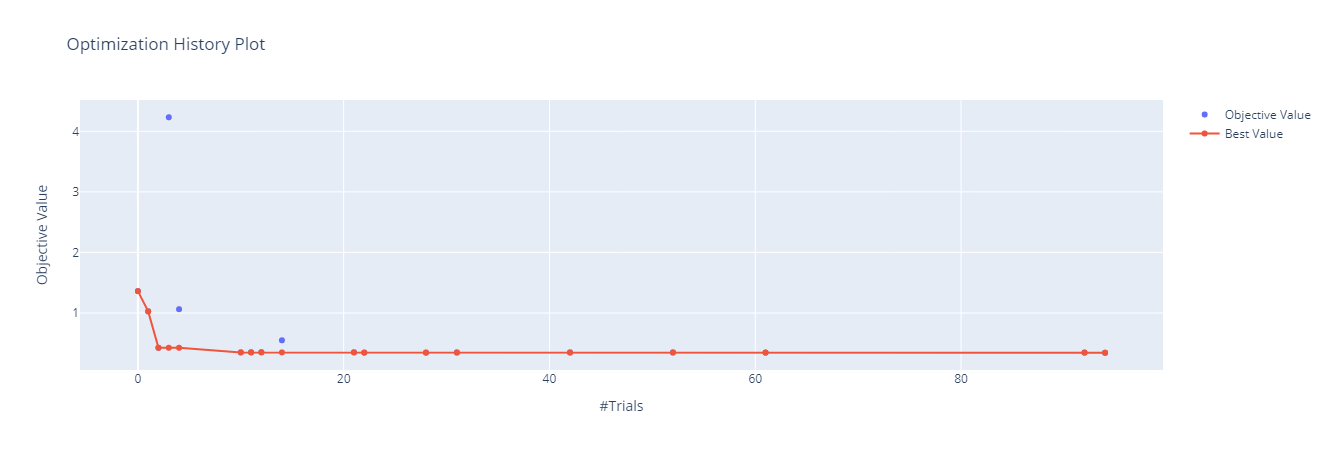

In [26]:
optuna.visualization.plot_optimization_history(study)

In [ ]:
optuna.visualization.plot_optimization_history(study).write_image("./export/optuna-optimization-history.svg")

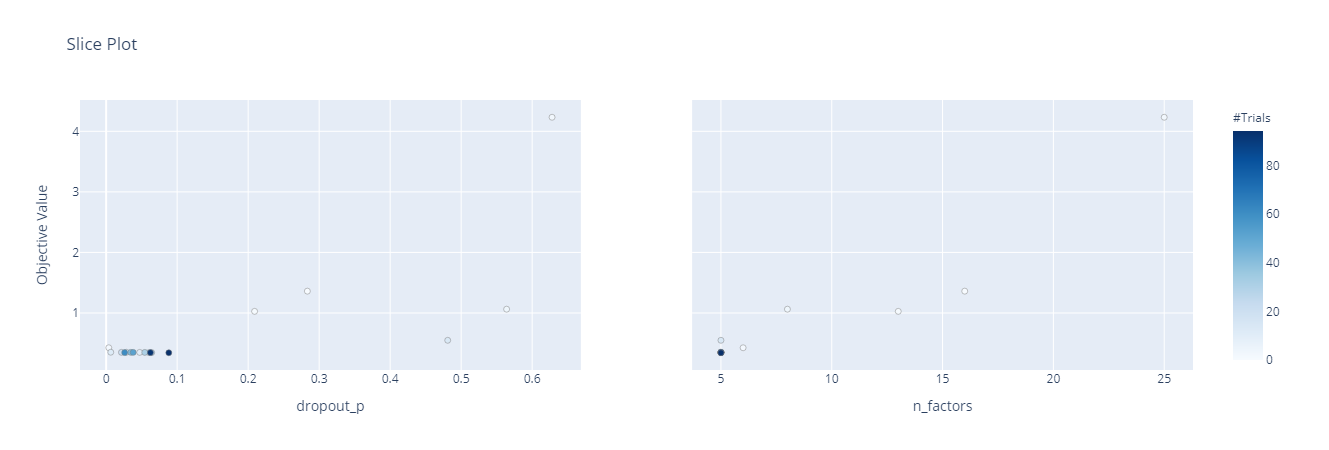

In [16]:
optuna.visualization.plot_slice(study)

In [27]:
optuna.visualization.plot_slice(study).write_image("./export/optuna-plot-slice.svg")

DEBUG:urllib3.connectionpool:Starting new HTTP connection (1): localhost:51110
DEBUG:urllib3.connectionpool:http://localhost:51110 "POST / HTTP/1.1" 200 24769


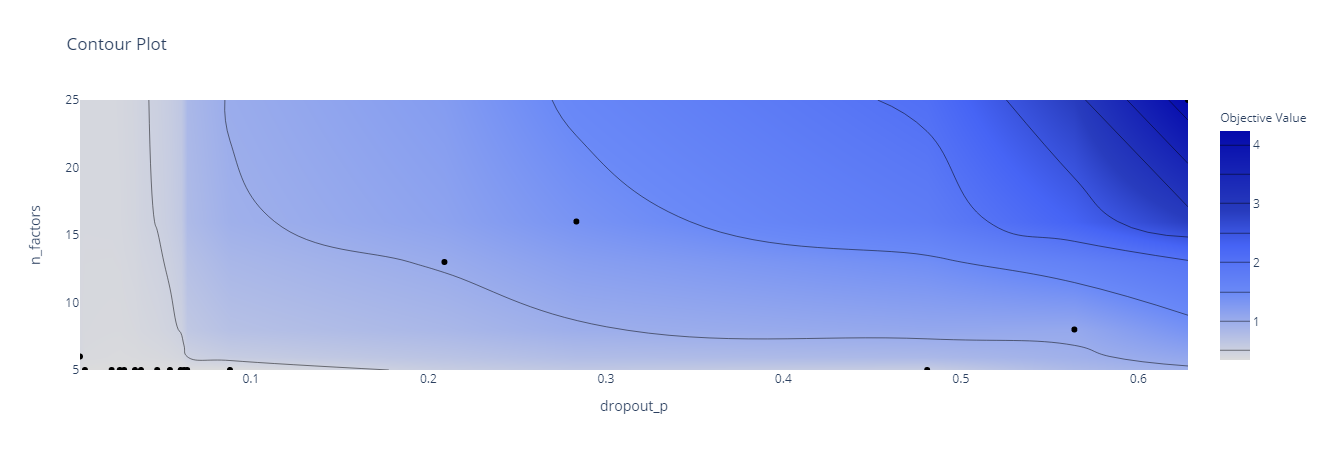

In [20]:
optuna.visualization.plot_contour(study, params=['n_factors', 'dropout_p'])

In [28]:
optuna.visualization.plot_contour(study, params=['n_factors', 'dropout_p']).write_image("./export/optuna-plot-contour.svg")

DEBUG:urllib3.connectionpool:Starting new HTTP connection (1): localhost:51110
DEBUG:urllib3.connectionpool:http://localhost:51110 "POST / HTTP/1.1" 200 85483


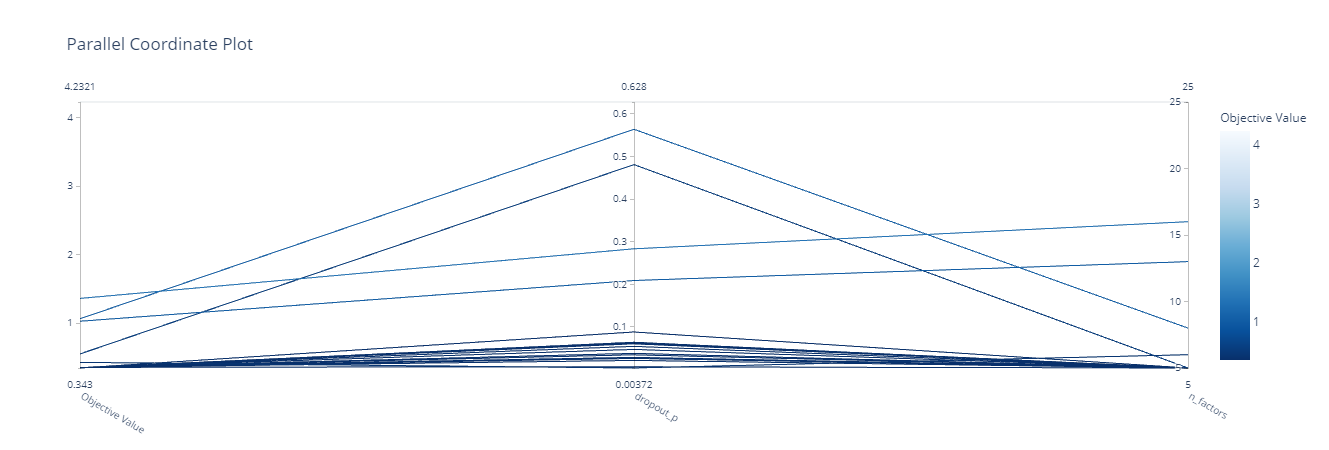

In [21]:
optuna.visualization.plot_parallel_coordinate(study)

In [29]:
optuna.visualization.plot_parallel_coordinate(study).write_image("./export/optuna-plot-parallel-coordinate.svg")

DEBUG:urllib3.connectionpool:Starting new HTTP connection (1): localhost:51110
DEBUG:urllib3.connectionpool:http://localhost:51110 "POST / HTTP/1.1" 200 78165
